In [155]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.cm as cm
import itertools


<span style="font-size:20pt;">Prepare Data for Plotting</span>

In [156]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [157]:
def process_year(year_str):
    return int(year_str.split(".")[-1])

def process_indicator_file(filepath):
    indicator_name = os.path.basename(filepath).split("_")[0]
    
    df = pd.read_csv(filepath)
    df_long = df.melt(id_vars=["country","code","iso"], var_name="year", value_name=indicator_name).drop(columns=["code"])
    df_long["year"] = df_long["year"].apply(process_year)
    
    return df_long

folder_path = "./selected_indicators/"
all_indicators = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        filepath = os.path.join(folder_path, filename)
        indicator_long = process_indicator_file(filepath)
        all_indicators.append(indicator_long)

merged_env = all_indicators[0]
for indicator_df in all_indicators[1:]:
    merged_env = pd.merge(merged_env, indicator_df, on=["country", "year", "iso"], how="outer")

merged_env

country  iso  year      OZD  NOE  COE  VOE  SOE   
0                   Afghanistan  AFG  1990   127.58  NaN  NaN  NaN  NaN  \
1                       Albania  ALB  1990    72.44  NaN  NaN  NaN  NaN   
2                       Algeria  DZA  1990    44.92  NaN  NaN  NaN  NaN   
3                       Andorra  AND  1990    33.87  NaN  NaN  NaN  NaN   
4                        Angola  AGO  1990    85.20  NaN  NaN  NaN  NaN   
...                         ...  ...   ...      ...  ...  ...  ...  ...   
6595  Wallis and Futuna Islands  WLF  2019 -8888.00 0.00 0.05 0.00 0.00   
6596             Western Sahara  ESH  2019 -8888.00 0.00 0.09 0.00 0.00   
6597                      Yemen  YEM  2019    54.86 0.01 0.19 0.03 0.02   
6598                     Zambia  ZMB  2019    35.44 0.00 0.18 0.05 0.01   
6599                   Zimbabwe  ZWE  2019    24.08 0.01 0.19 0.04 0.00   

          CDA      HAD      NDA      PMD  
0         NaN 13227.86      NaN  1057.88  
1         NaN  2633.13      NaN  1224.50  
2         NaN   715.55      NaN  2492.61  
3         NaN     3.37      NaN   451.89  
4         NaN  9808.61      NaN   641.75  
...       ...      ...      ...      ...  
6595 -8888.00 -8888.00 -8888.00 -8888.00  
6596 -8888.00 -8888.00 -8888.00 -8888.00  
6597    -0.01  1949.31    -0.00  2229.57  
6598     0.12  3254.54     0.00  1084.60  
6599     0.03  4040.04    -0.03  1035.29  

[6600 rows x 12 columns]

In [158]:
weo = pd.read_csv('./WEO_Data.csv')
weo_long = weo.melt(id_vars=["WEO Country Code", "ISO", "Country", "Subject Descriptor", "Units", "Scale", "Country/Series-specific Notes", "Estimates Start After"],
                                               var_name="year", value_name="value")
weo_long["indicator"] = weo_long["Subject Descriptor"] + " (" + weo_long["Units"] + ")"
weo_long = weo_long[["year", "ISO", "indicator", "value"]]
weo_long['year'] = pd.to_numeric(weo_long['year'], errors='coerce').astype(int)
weo_long['value'] = pd.to_numeric(weo_long['value'], errors='coerce')
reshaped_weo = weo_long.pivot_table(index=['year', "ISO"], columns='indicator', values='value').reset_index()
reshaped_weo.columns.name = None
reshaped_weo = reshaped_weo.rename(columns={"ISO":"iso", "Gross domestic product constant prices (National currency)":"GDP-N", "Gross domestic product constant prices (Percent change)":"GDP-P","Gross domestic product current prices (U.S. dollars)":"GDP-U","Gross domestic product per capita constant prices (National currency)":"GDPPC-N","Gross domestic product per capita current prices (U.S. dollars)":"GDPPC-U","Population (Persons)":"Population"})
reshaped_weo

year  iso    GDP-N  GDP-P    GDP-U   GDPPC-N  GDPPC-U  Population
0    1995  ARG   422.63  -2.85   288.50  12151.83  8295.12       34.78
1    1995  AUS   983.66   2.96   379.07  54287.19 20920.47       18.12
2    1995  BRA   705.99   4.42   770.86   4443.70  4851.99      158.88
3    1995  CAN  1188.66   2.69   605.94  40619.98 20706.73       29.26
4    1995  CHN 11473.20  10.97   731.00   9472.51   603.53     1211.21
..    ...  ...      ...    ...      ...       ...      ...         ...
471  2022  KEN  9895.90   5.37   115.99 194327.41  2277.69       50.92
472  2022  MEX 18355.59   3.07  1414.10 141068.44 10867.81      130.12
473  2022  NGA 75768.95   3.25   477.38 349573.22  2202.46      216.75
474  2022  USA 20015.40   2.07 25464.48  60010.88 76348.49      333.53
475  2022  ZAF  4596.28   2.04   405.70  75841.25  6694.36       60.60

[476 rows x 8 columns]

In [159]:
merged_data = pd.merge(merged_env, reshaped_weo, on=["year", "iso"])
merged_data = merged_data.drop("iso", axis=1)
merged_data = merged_data.replace("United States of America", "USA")
merged_data['GDP-G'] = merged_data['GDP-N'] * merged_data['GDP-P'] / 100
merged_data

merged_data.to_csv("merged_data.csv", index=False)


<span style="font-size:20pt;">Select Indicators, Countries, and Custom Time Windows</span>

In [160]:
env_1 = ['SOE', 'VOE', 'COE', 'NOE']
weo_1 = ['GDP-U', 'GDPPC-U', 'GDP-G']
indicator_pairs_1 = list(itertools.product(weo_1, env_1))

env_2 = ['SOE', 'VOE', 'COE', 'NOE']
weo_2 = ['GDP-U', 'GDPPC-U', 'GDP-G', 'Population']
indicator_pairs_2 = list(itertools.product(weo_2, env_2))

env_3 = ['NDA', 'CDA']
weo_3 = ['GDP-P']
indicator_pairs_3 = list(itertools.product(weo_3, env_3))

continent_dict = {  
    'Japan': 'Asia',
    'Argentina': 'South America',
    'Australia': 'Oceania',
    'Brazil': 'South America',
    'Canada': 'North America',
    'China': 'Asia',
    'Denmark': 'Europe',
    'Finland': 'Europe',
    'France': 'Europe',
    'Germany': 'Europe',
    'India': 'Asia',
    'Italy': 'Europe',
    'Japan': 'Asia',
    'Kenya': 'Africa',
    'Mexico': 'North America',
    'Nigeria': 'Africa',
    'South Africa': 'Africa',
    'USA': 'North America',
    'Uruguay': 'Sounth America'
}

continent_colors = {
    "Asia": cm.Blues(0.5),
    "Europe": cm.Blues(0.2),
    "Africa": "#5B9C9C",
    "Europe":  cm.magma(0.3),
    "North America": "#5276A7",
    "South America": "#8E5B9B",
    "Oceania": cm.Blues(0.8)
}

continent_order = ['Africa', 'Asia', 'South America',
                   'Europe', 'North America',  'Oceania']

organization_dict = {
    'Canada': 'NAFTA',
    'Mexico': 'NAFTA',
    'USA': 'NAFTA',
    'Brazil': 'BRICS',
    'Russia': 'BRICS',
    'India': 'BRICS',
    'China': 'BRICS',
    'South Africa': 'BRICS',
}

eu_countries = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Republic of Cyprus', 'Czech Republic', 'Denmark',
    'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia',
    'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia',
    'Slovenia', 'Spain', 'Sweden'
]

for country in eu_countries:
    organization_dict[country] = 'EU'


custom_windows = [(2003, 2008), (2009, 2013), (2014, 2019)]
selected_countries = ['China', 'India', 'USA', 'Denmark', 'Germany']

<span style="font-size:20pt;">Plotting Pearson Correlation of `indicator_pairs_1` for Selected Countries in Three Time Windows - Time</span>

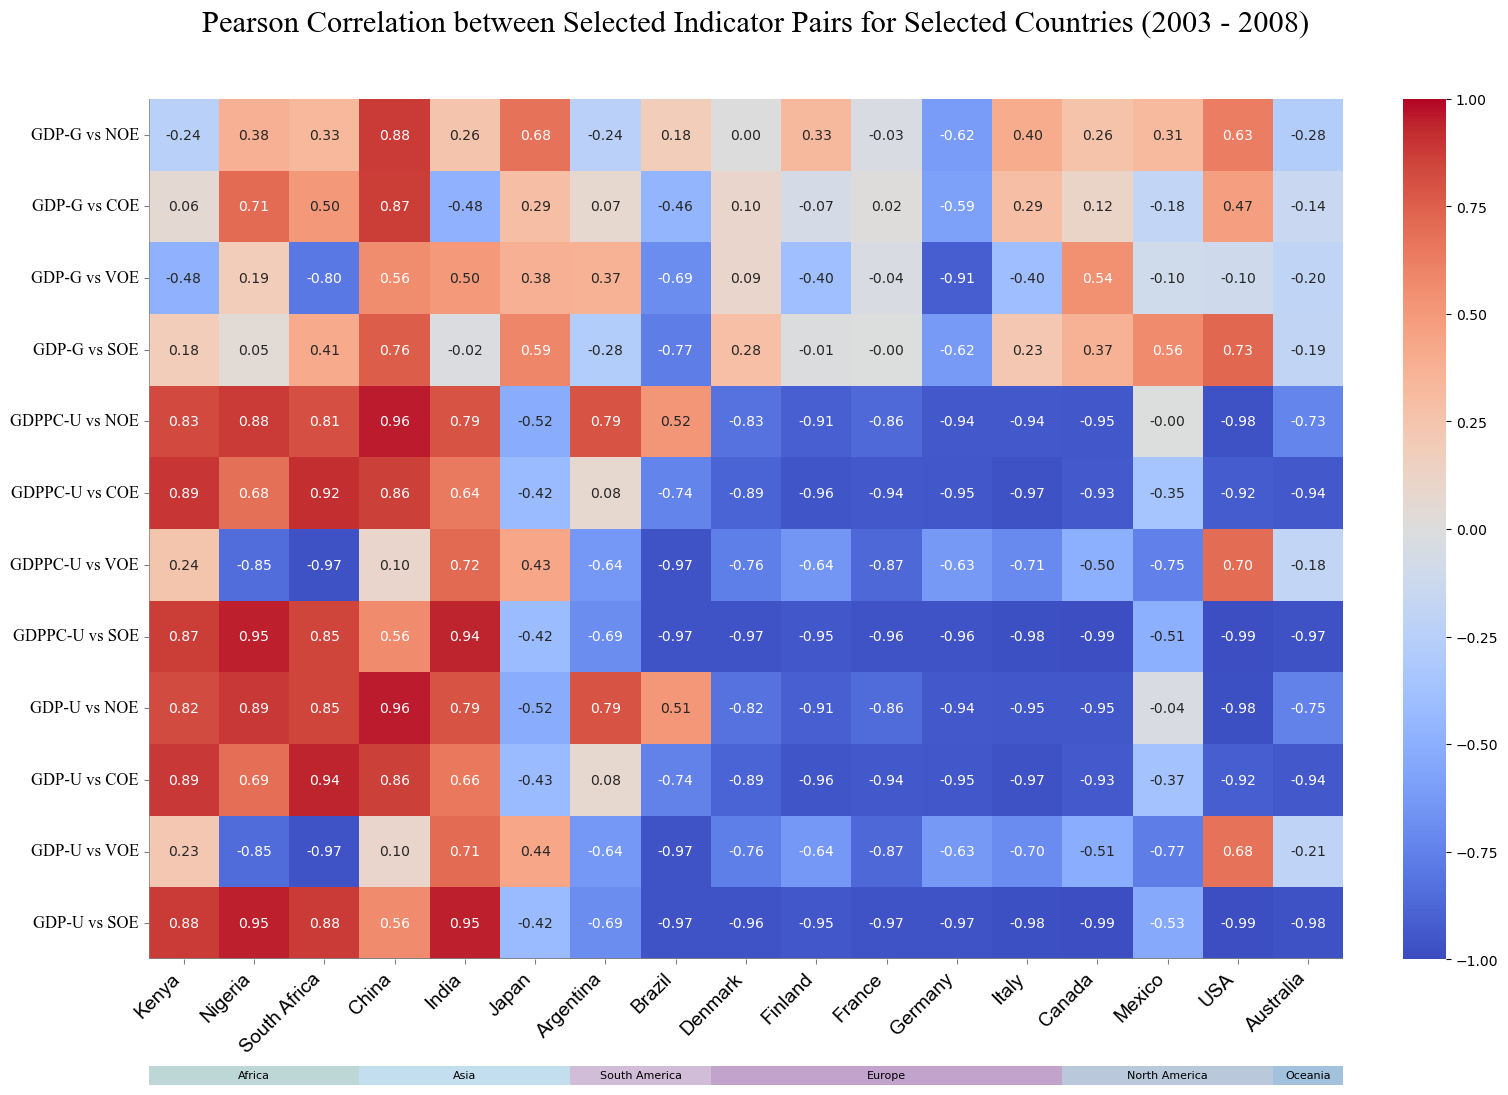

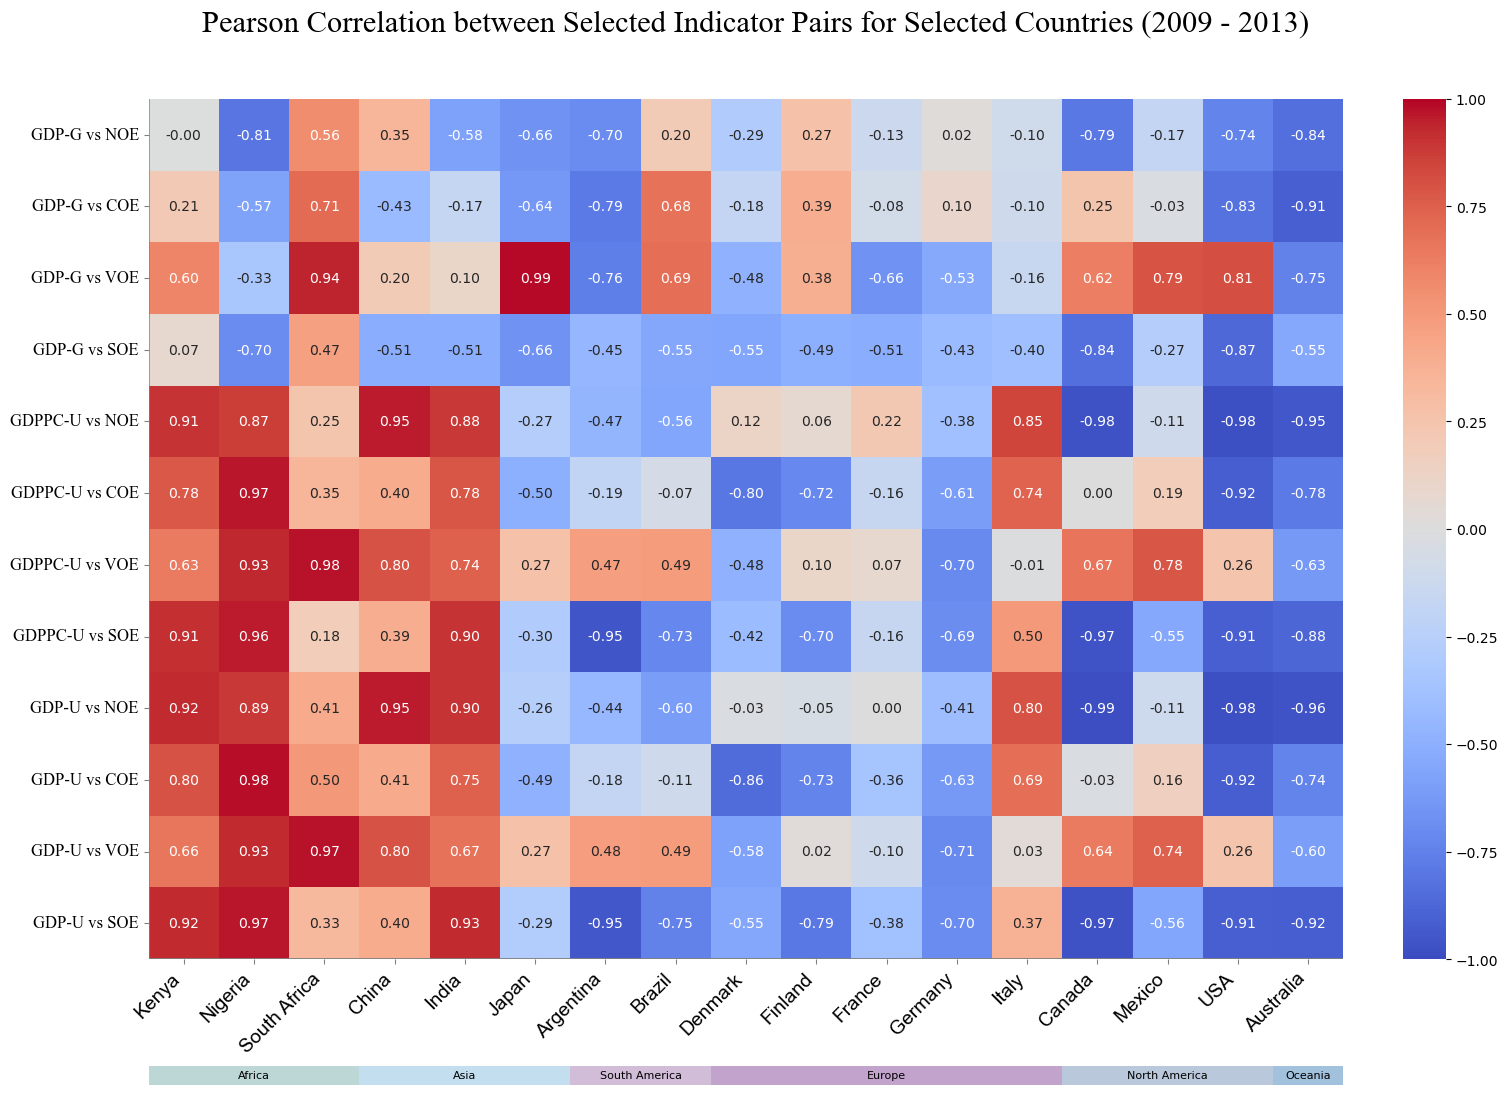

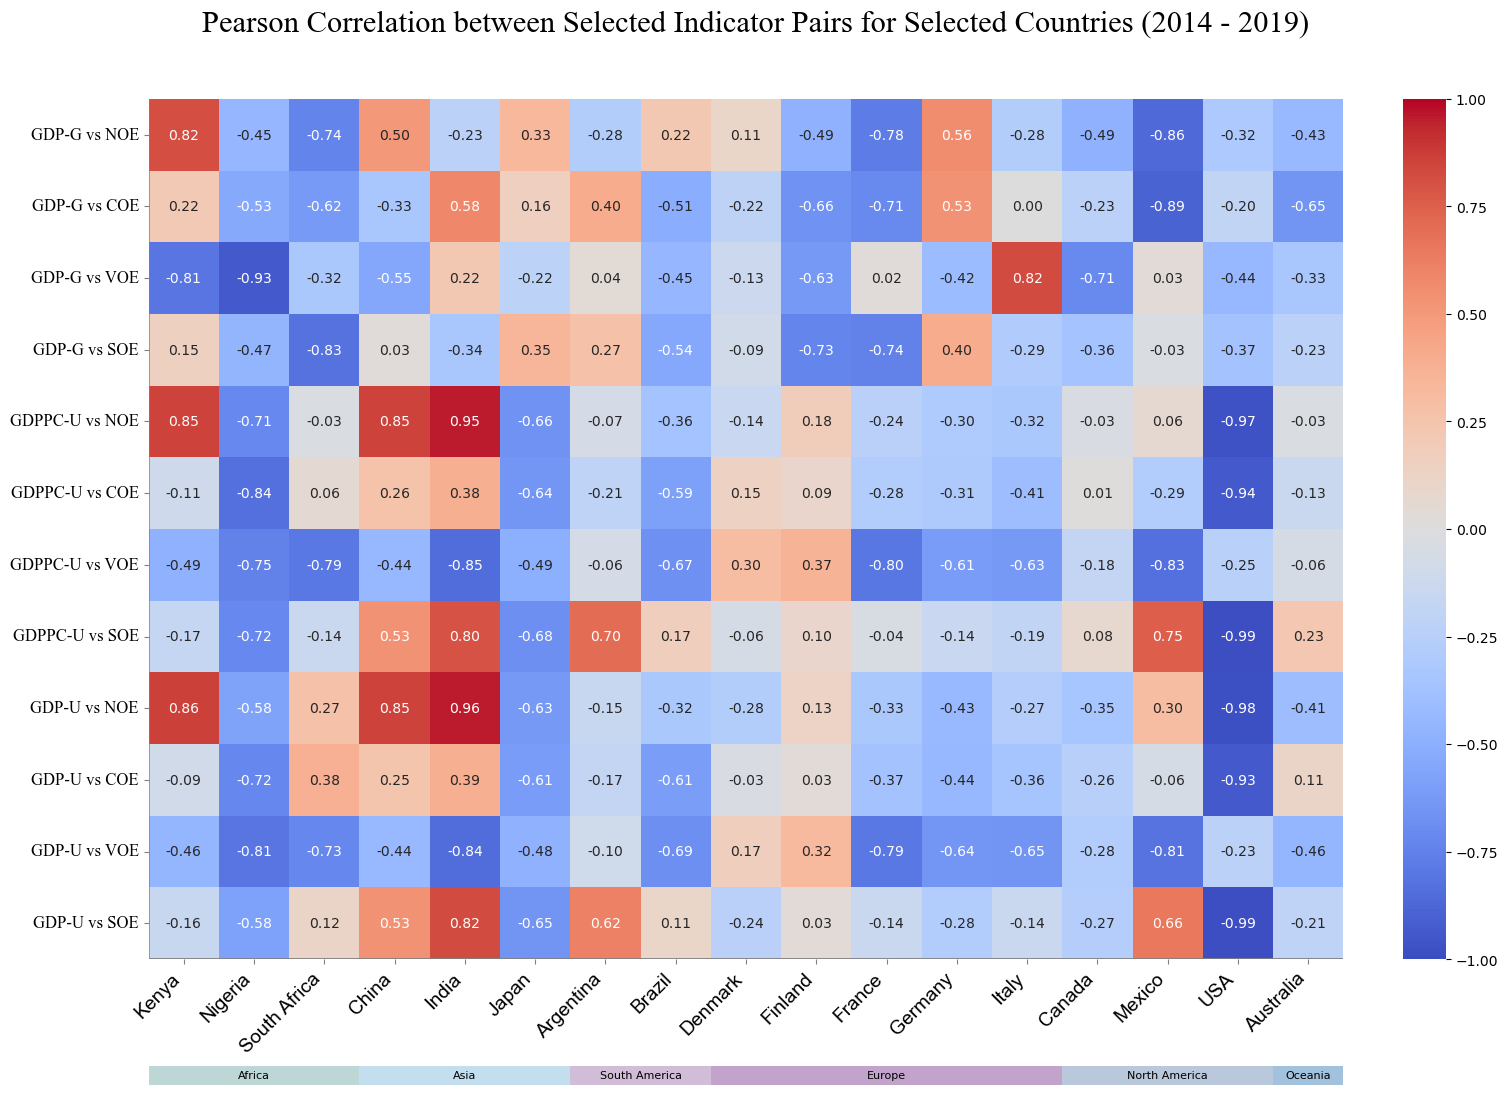

In [161]:
unique_countries = merged_data["country"].unique()
countries_with_continent = [(country, continent_dict[country])
                            for country in unique_countries]
sorted_countries = sorted(countries_with_continent,
                          key=lambda x: (continent_order.index(x[1]), x[0]))
sorted_country_names = [country for country, _ in sorted_countries]


def compute_window_correlation(data, indicator_pairs, year_start, year_end):
    data_window = data[(data["year"] >= year_start)
                       & (data["year"] <= year_end)]
    correlation_matrix = np.zeros(
        (len(indicator_pairs), len(sorted_country_names)))

    for i, (indicator1, indicator2) in enumerate(indicator_pairs):
        correlations = data_window.groupby("country").apply(
            lambda group: group[indicator1].corr(group[indicator2]))
        correlations = correlations.loc[sorted_country_names]
        correlation_matrix[i, :] = correlations.values
        correlation_df = pd.DataFrame(correlation_matrix, columns=sorted_country_names, index=[
                                      f"{pair[0]} vs {pair[1]}" for pair in indicator_pairs])

    return correlation_df
                

def plot_single_heatmap(correlation_df, year_start, year_end):
    fig, (ax, ax_bar) = plt.subplots(2, 1, figsize=(
        15, 10), gridspec_kw={'height_ratios': [45, 1]}, constrained_layout=True)
    sns.heatmap(correlation_df, annot=True, fmt=".2f",
                cmap="coolwarm", cbar=True, vmin=-1, vmax=1, ax=ax)
    x_label_font = {'fontname': 'Arial', 'size': 14}
    ax.set_xticklabels(correlation_df.columns, rotation=45,
                       ha='right', fontdict=x_label_font)
    y_label_font = {'fontname': 'Times New Roman', 'size': 12}
    ax.set_yticklabels(correlation_df.index, rotation=0, fontdict=y_label_font)
    ax.invert_yaxis()
    ax.axhline(y=0, color='gray', linewidth=2)
    ax.axvline(x=0, color='gray', linewidth=0.5)
    ax.tick_params(axis='both', which='both', color='gray')
    title_font = {'fontname': 'Times New Roman','weight': 'bold'}
    fig.suptitle(f"Pearson Correlation between Selected Indicator Pairs for Selected Countries ({year_start} - {year_end})", y=1.08, fontdict=title_font, fontsize=22)



    xticks = ax.get_xticks()
    continent_boundaries = [0] + [(xticks[i] + xticks[i - 1])/2 for i in range(1, len(xticks)) if dict(countries_with_continent)[
        correlation_df.columns[i]] != dict(countries_with_continent)[correlation_df.columns[i - 1]]] + [xticks[-1] + 0.5]    

    for i in range(len(continent_order)):
        start_tick = continent_boundaries[i]
        end_tick = continent_boundaries[i + 1]
        continent = continent_order[i]
        color = continent_colors[continent]

        ax_bar.axvspan(start_tick, end_tick, ymin=0,
                       ymax=1, color=color, alpha=0.4, lw=0)
        ax_bar.text((start_tick + end_tick) / 2, 0.5, continent,
                    ha='center', va='center', fontsize=8)

    ax_bar.set_xlim(ax.get_xlim())
    ax_bar.set_ylim(0, 1)
    ax_bar.set_yticks([])
    ax_bar.set_xticks([])
    ax_bar.spines['top'].set_visible(False)
    ax_bar.spines['right'].set_visible(False)
    ax_bar.spines['left'].set_visible(False)
    ax_bar.spines['bottom'].set_visible(False)

    
    plt.savefig(
        f"Pearson Correlation between Selected Indicator Pairs for Selected Countries ({year_start} - {year_end})", dpi=800, bbox_inches='tight')
    plt.show()


for year_start, year_end in custom_windows:
    correlation_df = compute_window_correlation(
        merged_data, indicator_pairs_1, year_start, year_end)
    plot_single_heatmap(correlation_df, year_start, year_end)


<span style="font-size:20pt;">Plotting Pearson Correlation of `indicator_pairs_1` for Selected Countries in Three Time Windows - Country</span>

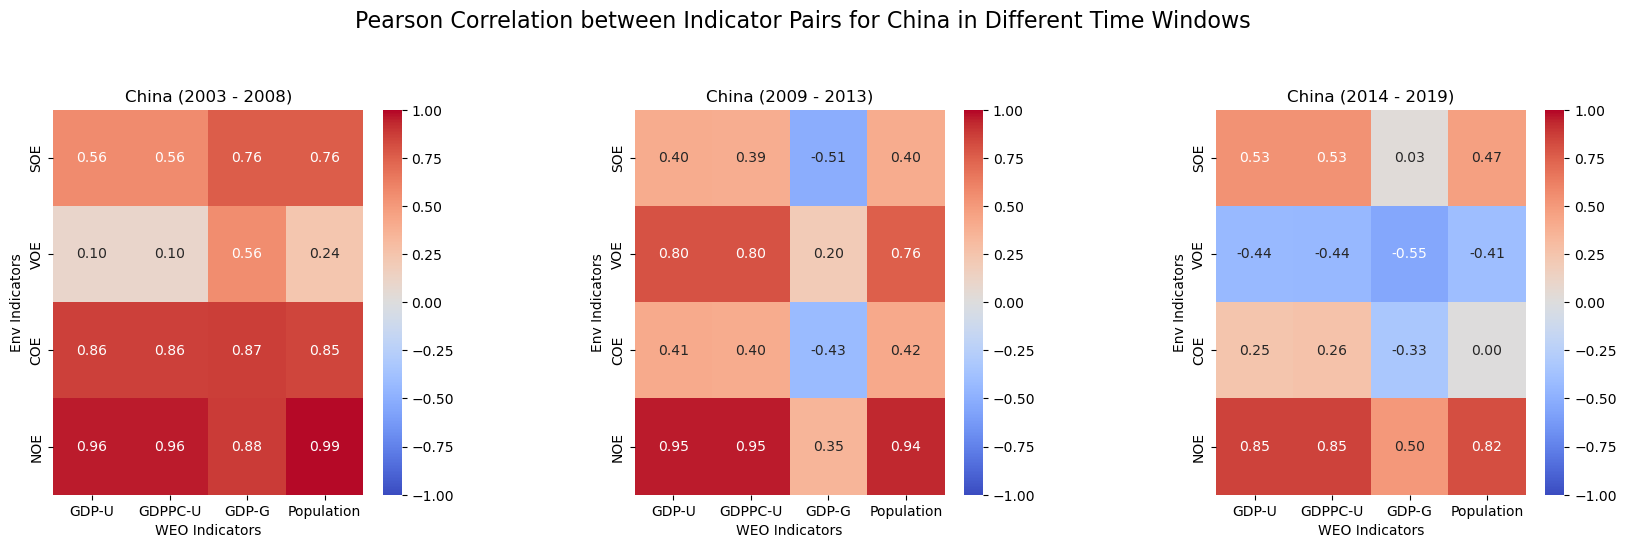

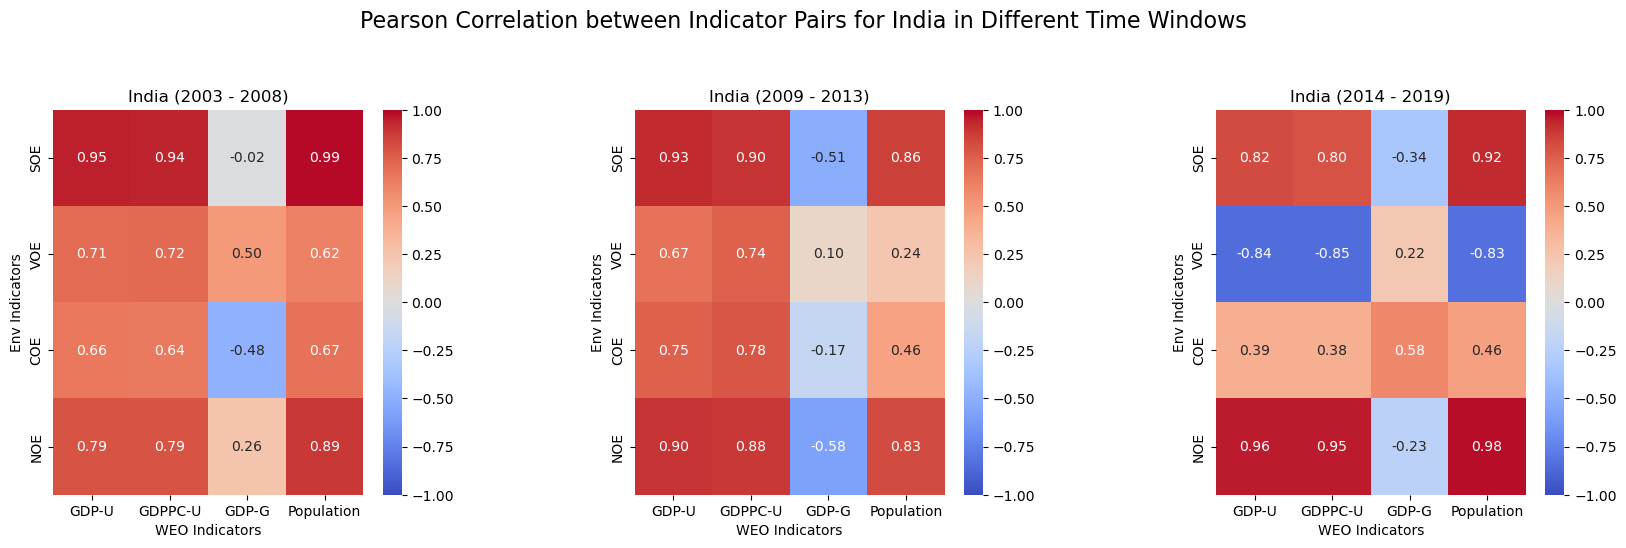

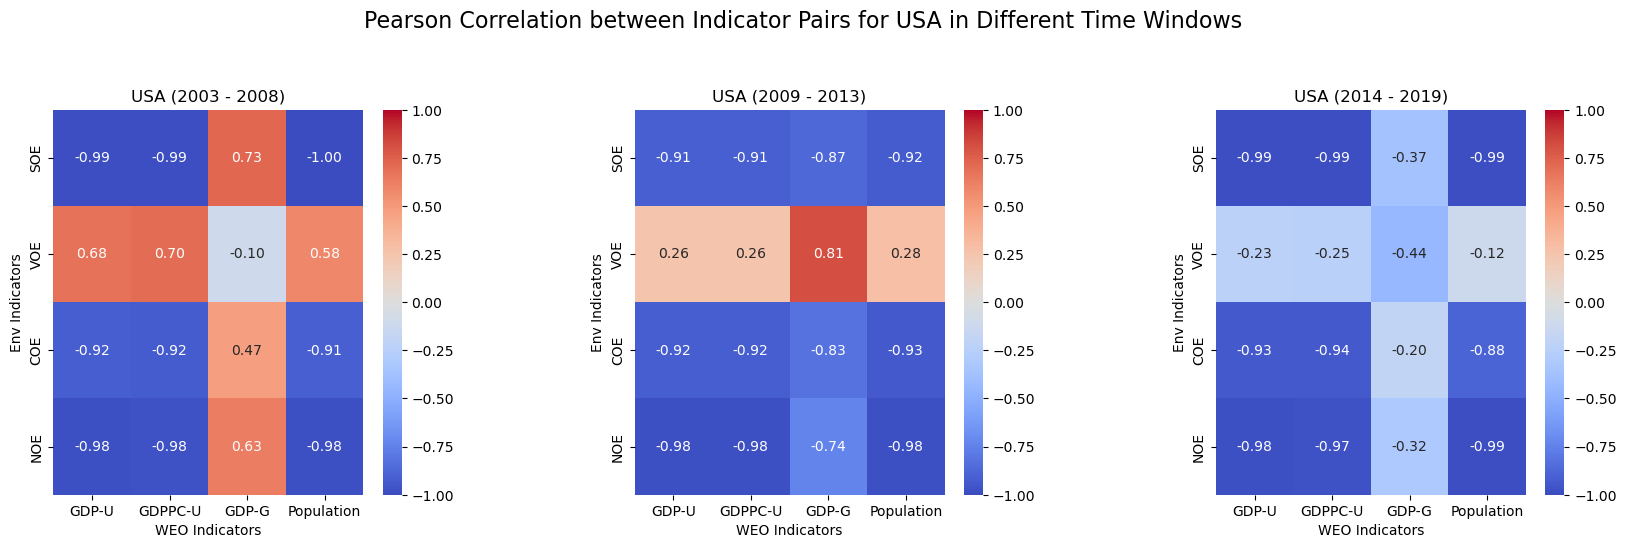

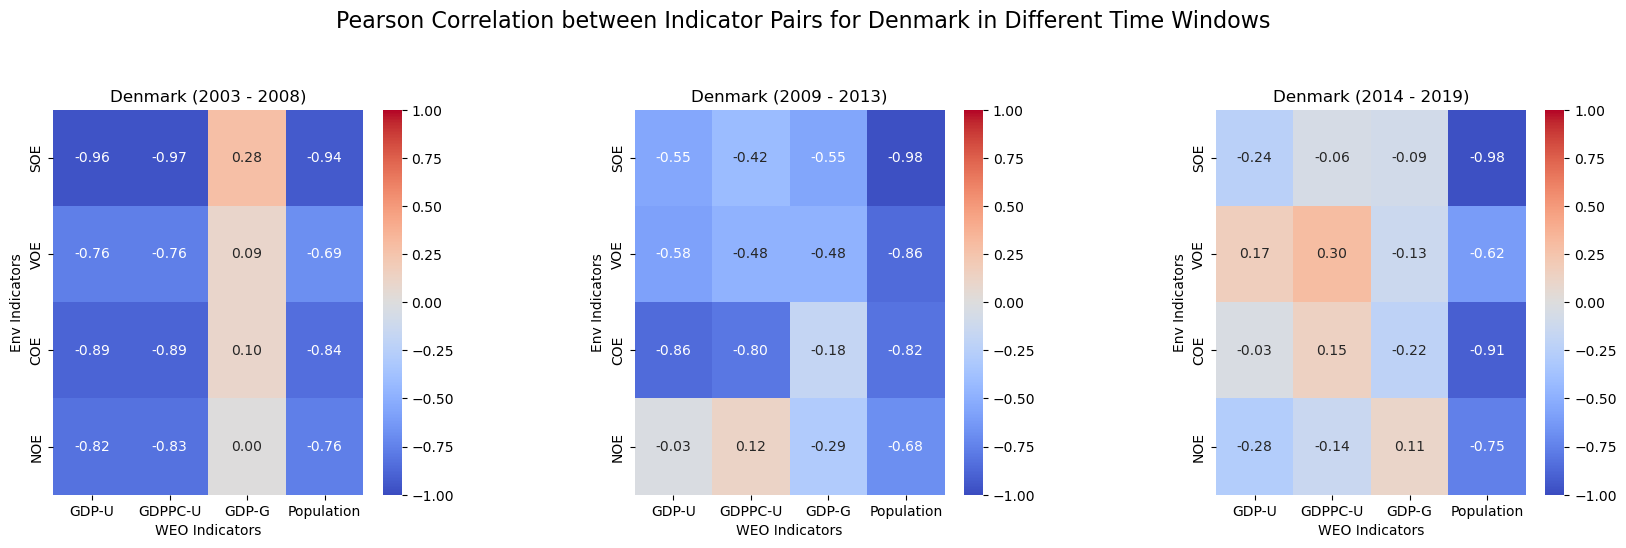

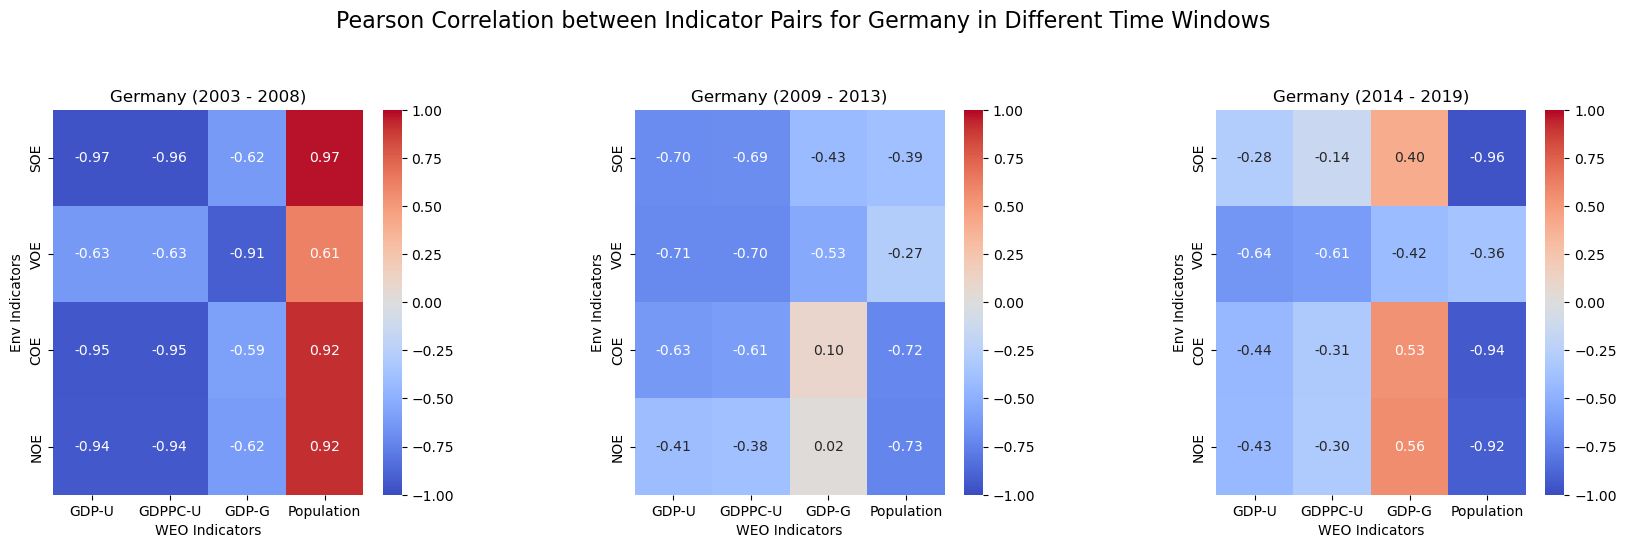

In [162]:
def plot_correlation_heatmap(data, country, custom_windows, env_indicators, weo_indicators):
    fig, axes = plt.subplots(nrows=1, ncols=len(
        custom_windows), figsize=(20, 5))
    plt.subplots_adjust(wspace=0.5)

    for i, (year_start, year_end) in enumerate(custom_windows):
        data_window = data[(data["year"] >= year_start) & (
            data["year"] <= year_end) & (data["country"] == country)]
        correlation_df = pd.DataFrame(
            index=env_indicators, columns=weo_indicators)

        for indicator1 in env_indicators:
            for indicator2 in weo_indicators:
                correlation = data_window[indicator1].corr(
                    data_window[indicator2])
                correlation_df.loc[indicator1, indicator2] = correlation
                
        correlation_df = correlation_df.astype(float)

        ax = axes[i]
        sns.heatmap(correlation_df, annot=True, fmt=".2f",
                    cmap="coolwarm", cbar=True, vmin=-1, vmax=1, ax=ax)
        ax.set_title(f"{country} ({year_start} - {year_end})")
        ax.set_xlabel("WEO Indicators")
        ax.set_ylabel("Env Indicators")

    plt.suptitle(
        f"Pearson Correlation between Indicator Pairs for {country} in Different Time Windows", y=1.08, fontsize=16)
    plt.savefig(
        f"Pearson Correlation between Indicator Pairs for {country} in Different Time Windows", dpi=800, bbox_inches='tight')
    plt.show()

for country in selected_countries:
    plot_correlation_heatmap(merged_data, country,
                             custom_windows, env_2, weo_2)

<span style="font-size:20pt;">Plotting Pearson Correlation of `indicator_pairs_2` for Main Continents Over Time</span>

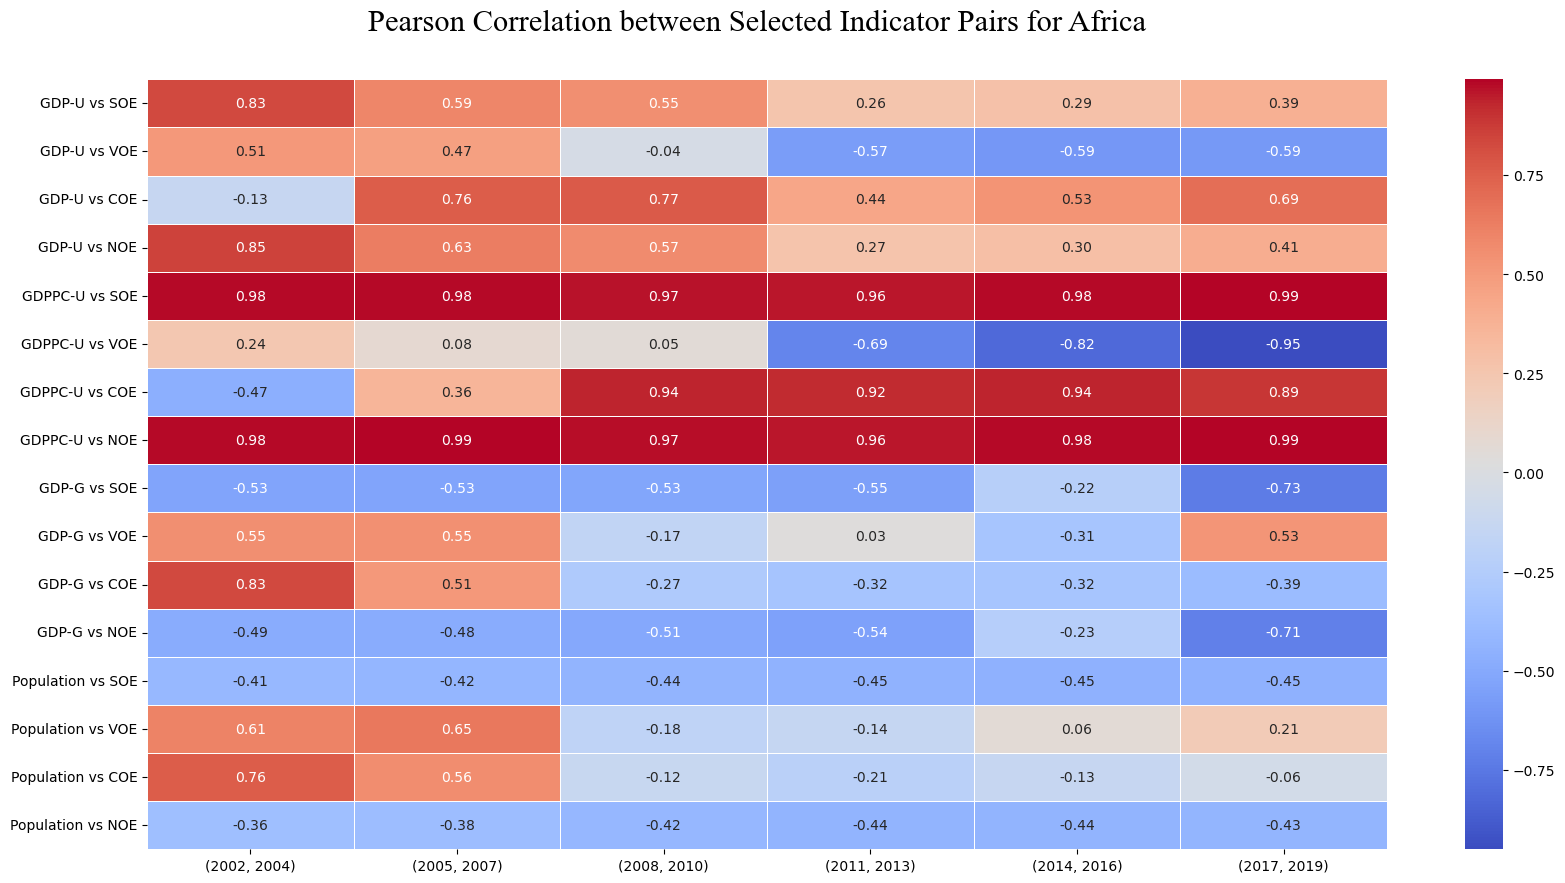

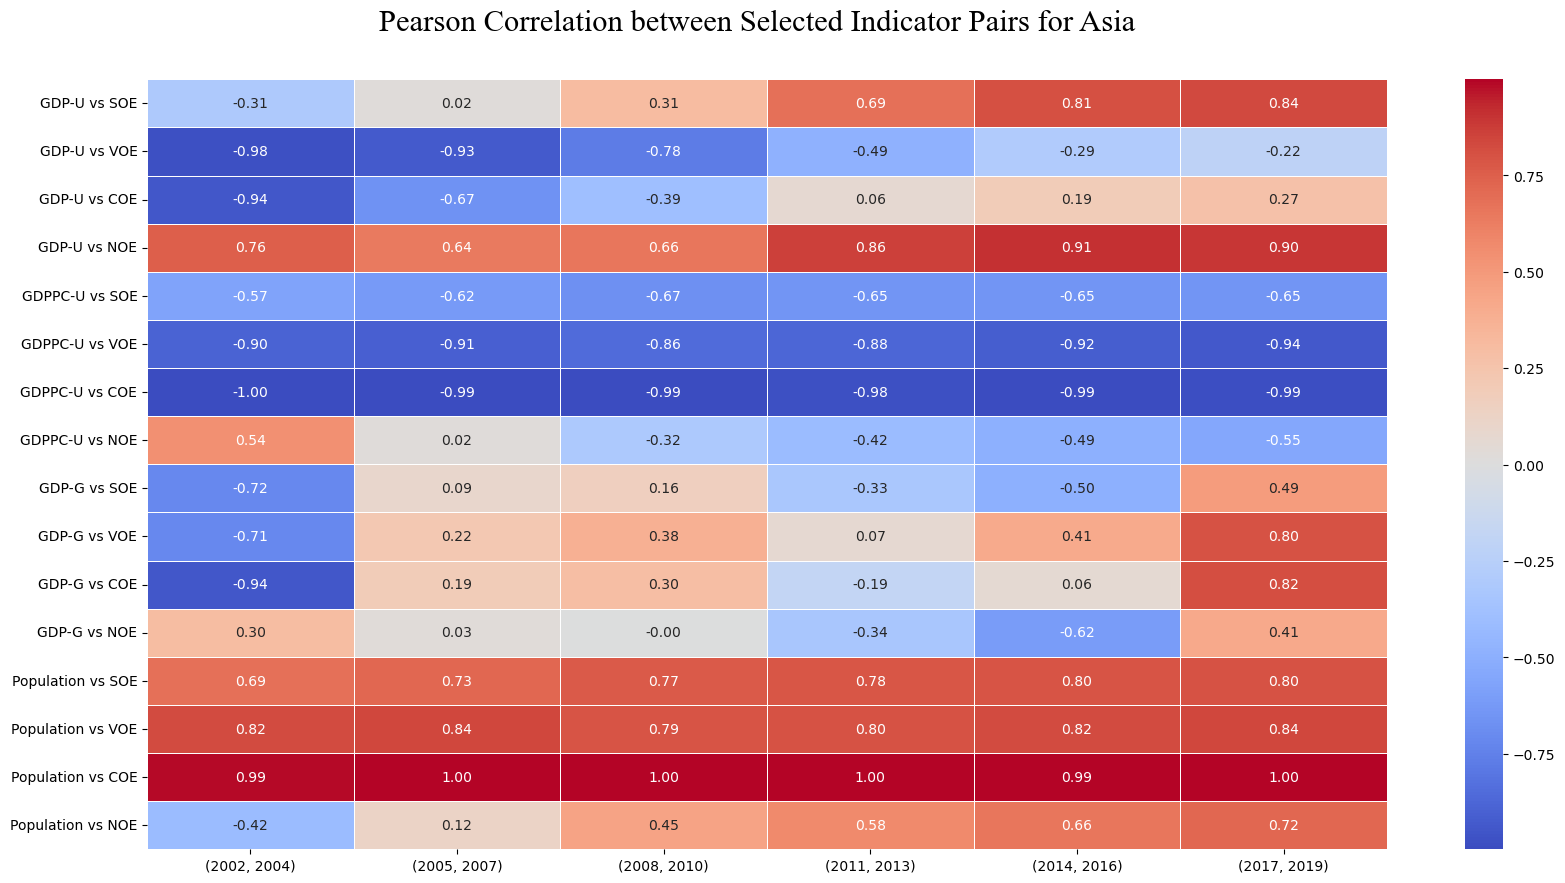

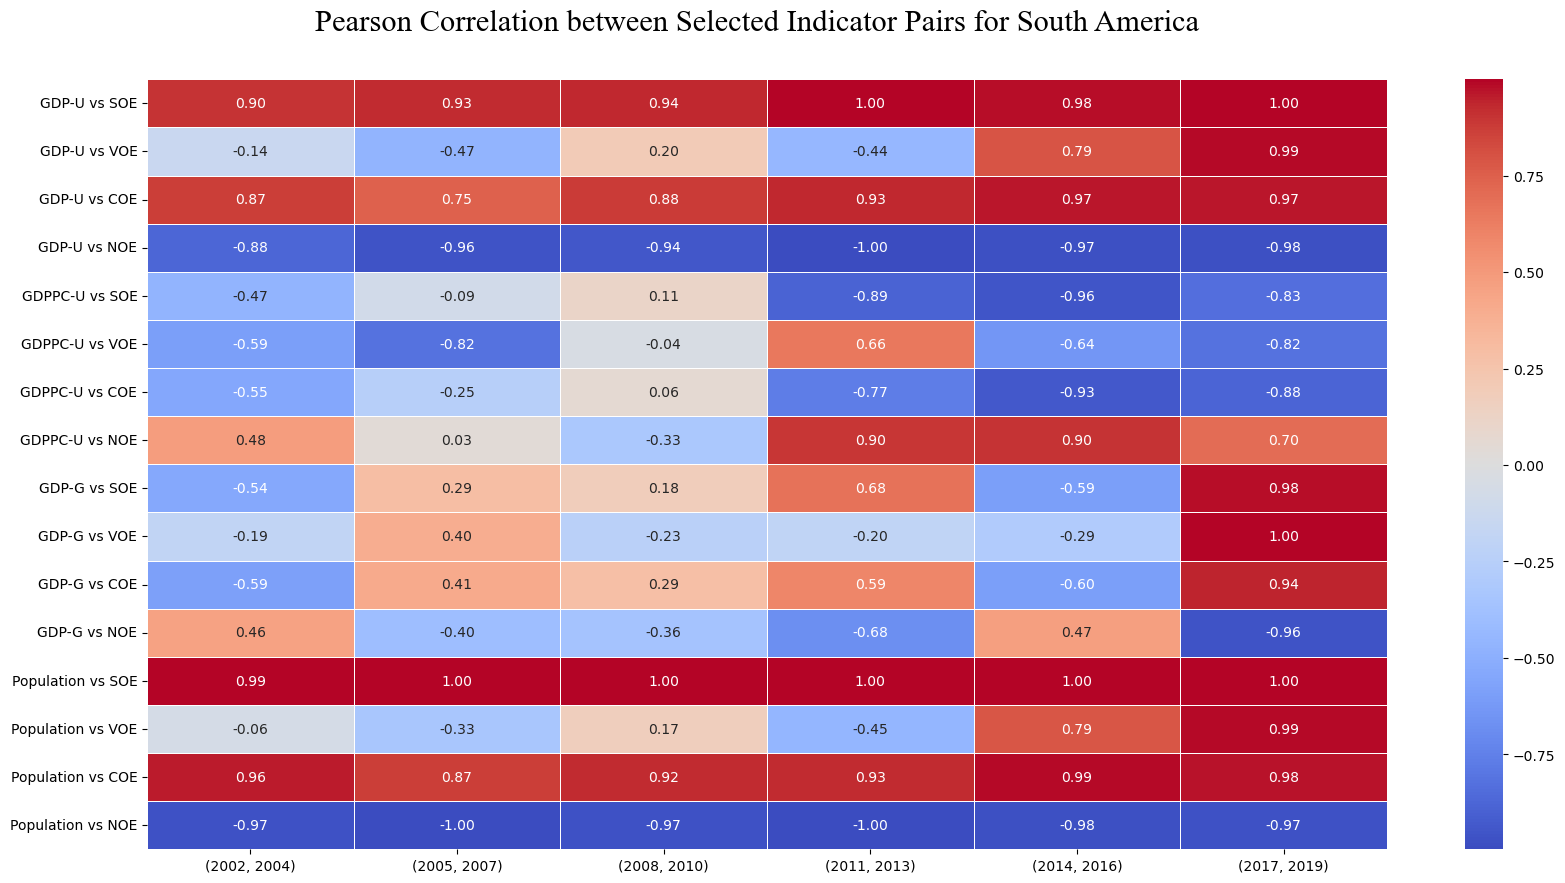

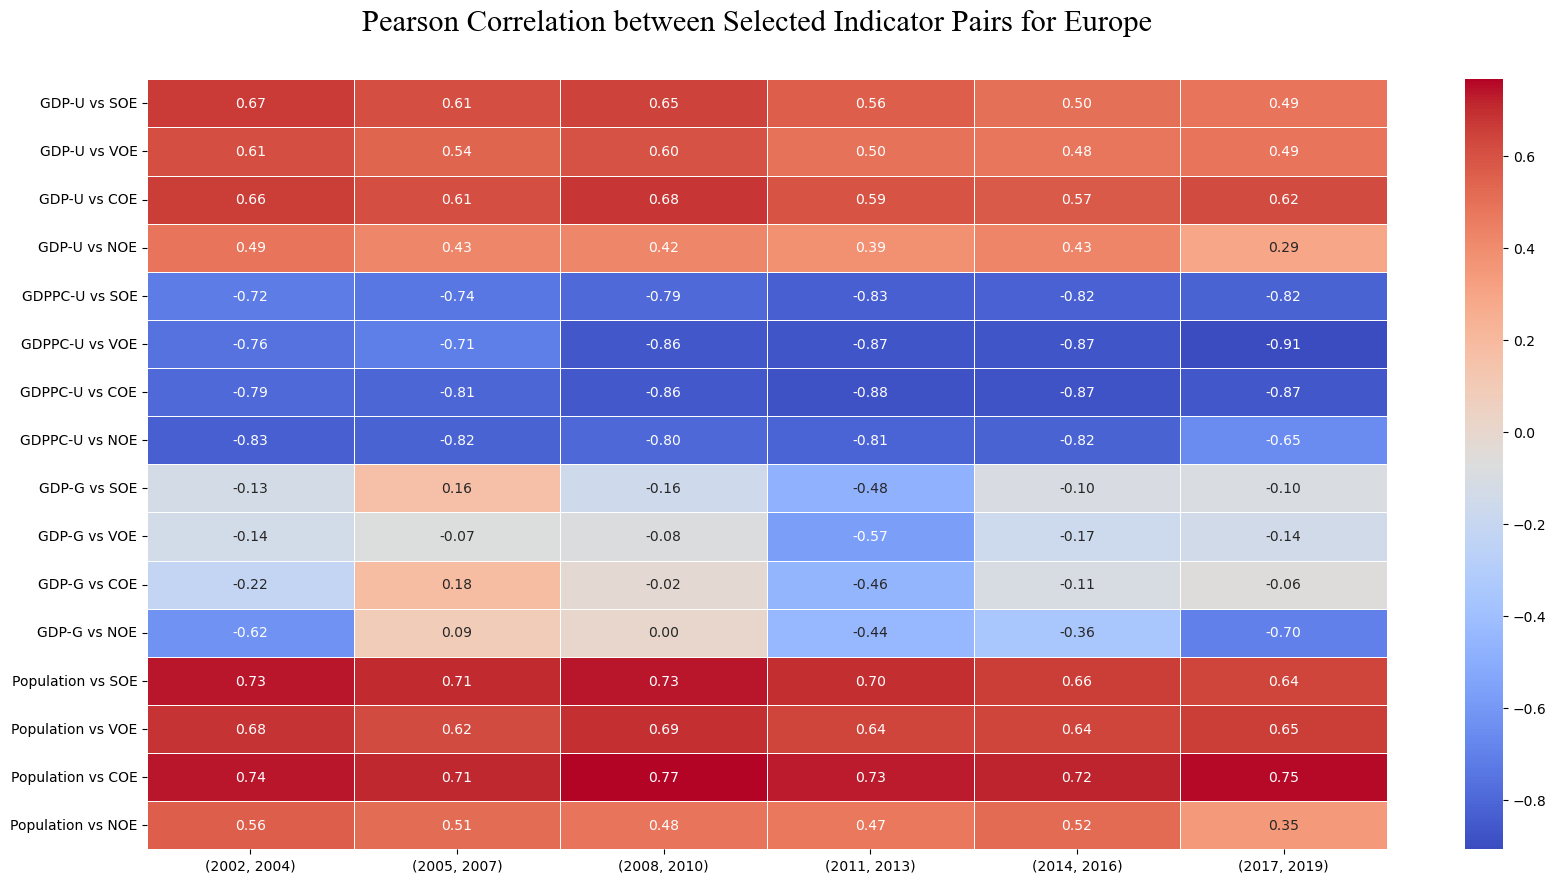

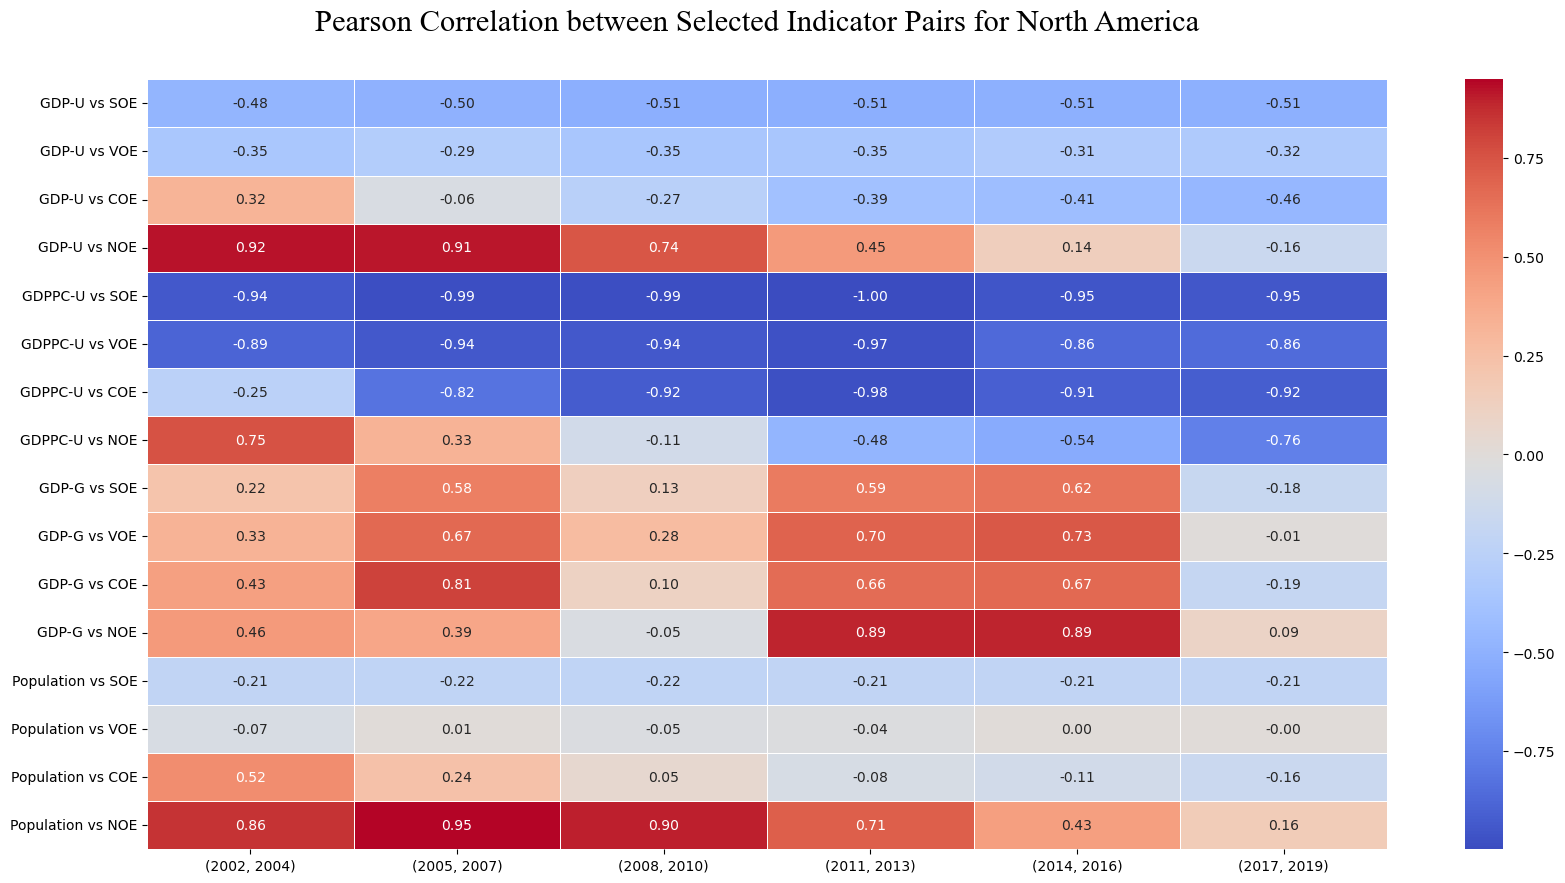

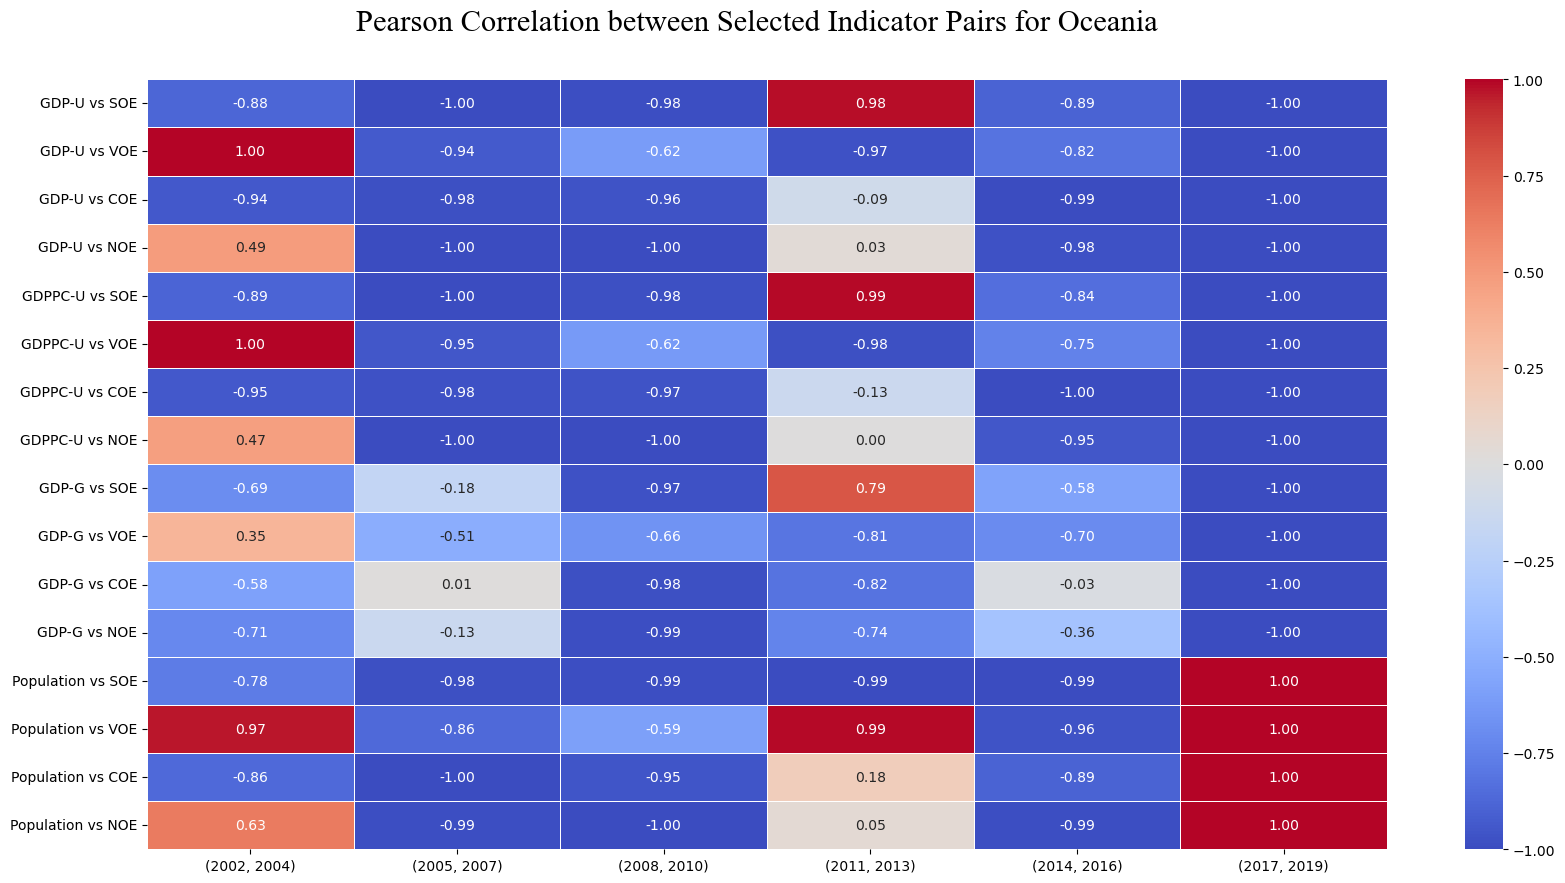

In [163]:
def get_continent_data(data, continent_dict):
    continent_data = data.copy()
    continent_data['continent'] = continent_data['country'].map(continent_dict)
    return continent_data

def plot_continent_heatmap(continent, continent_data, indicator_pairs):
    continent_data = continent_data[continent_data["continent"] == continent]
    start_year = 2002
    end_year = 2019
    year_intervals = [(y, y + 2) for y in range(start_year, end_year - 1, 3)]

    correlation_matrix = np.zeros((len(indicator_pairs), len(year_intervals)))
    year_grouped = continent_data.groupby(pd.cut(continent_data['year'], bins=[
                                          interval[0] for interval in year_intervals] + [year_intervals[-1][1]]))

    for i, (indicator1, indicator2) in enumerate(indicator_pairs):
        correlations = year_grouped.apply(
            lambda group: group[indicator1].corr(group[indicator2]))
        correlation_matrix[i, :] = correlations.values
    correlation_df = pd.DataFrame(correlation_matrix, columns=year_intervals,
                                  index=[f"{pair[0]} vs {pair[1]}" for pair in indicator_pairs])
    plt.figure(figsize=(20, 10))
    sns.heatmap(correlation_df, cmap='coolwarm', linewidths=0.5, annot=True, fmt=".2f")
    title_font = {'fontname': 'Times New Roman', 'weight': 'bold'}
    plt.suptitle(
        f"Pearson Correlation between Selected Indicator Pairs for {continent}", y=0.95, fontdict=title_font, fontsize=22, x=0.43, ha='center')
    plt.savefig(
        f"Pearson Correlation between Selected Indicator Pairs for {continent}", dpi=800, bbox_inches='tight')
    plt.show()


selected_countries = list(continent_dict.keys())
filtered_data = merged_data[merged_data['country'].isin(selected_countries)]
continent_data = get_continent_data(filtered_data, continent_dict)

for continent in continent_order:
    plot_continent_heatmap(continent, continent_data, indicator_pairs_2)

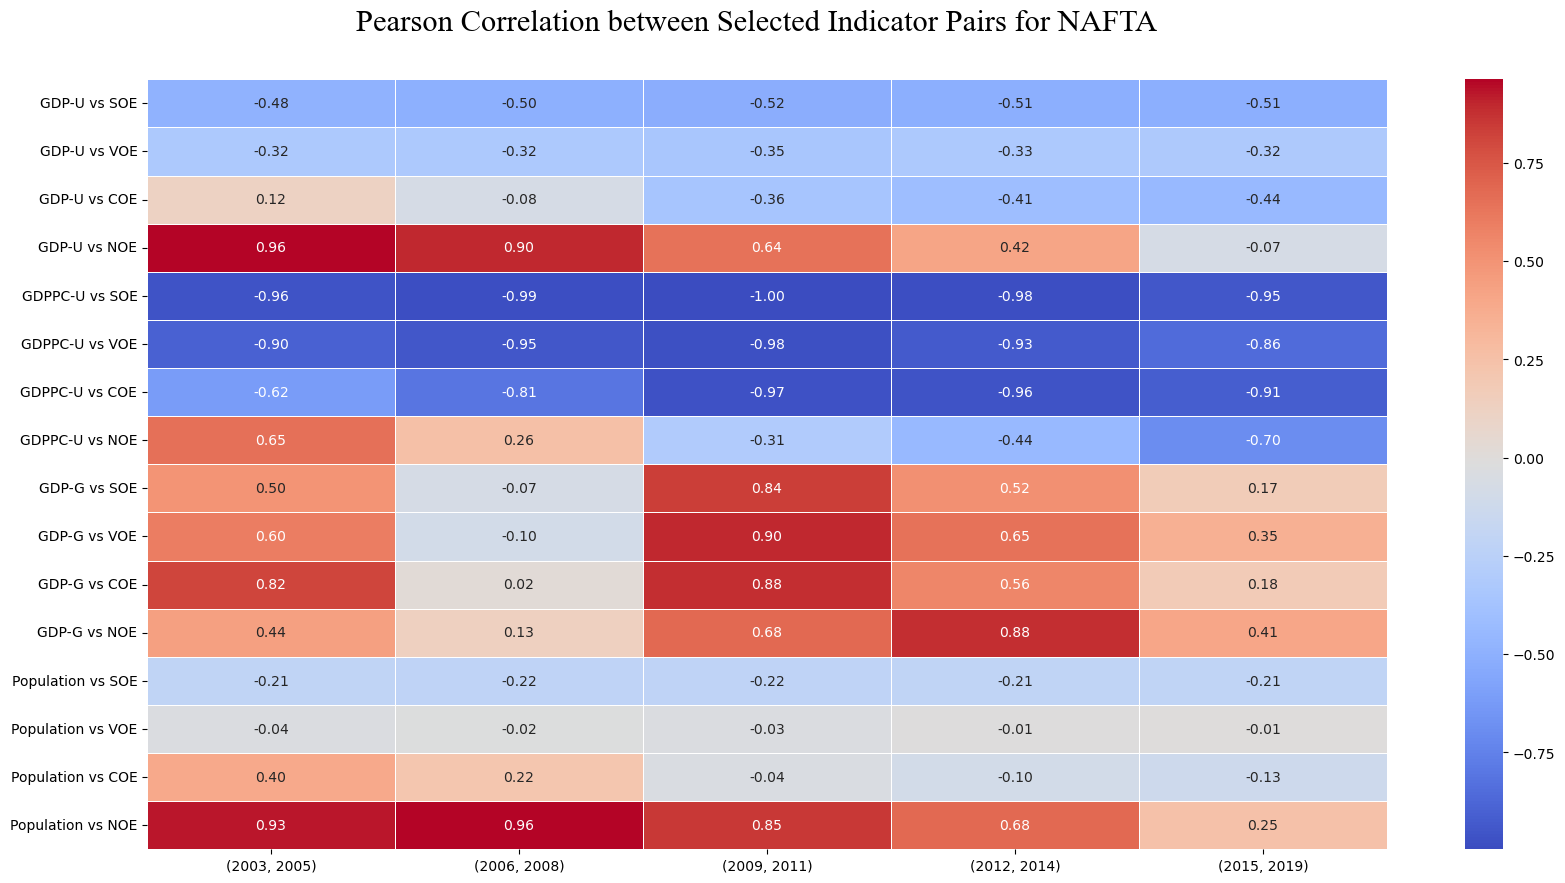

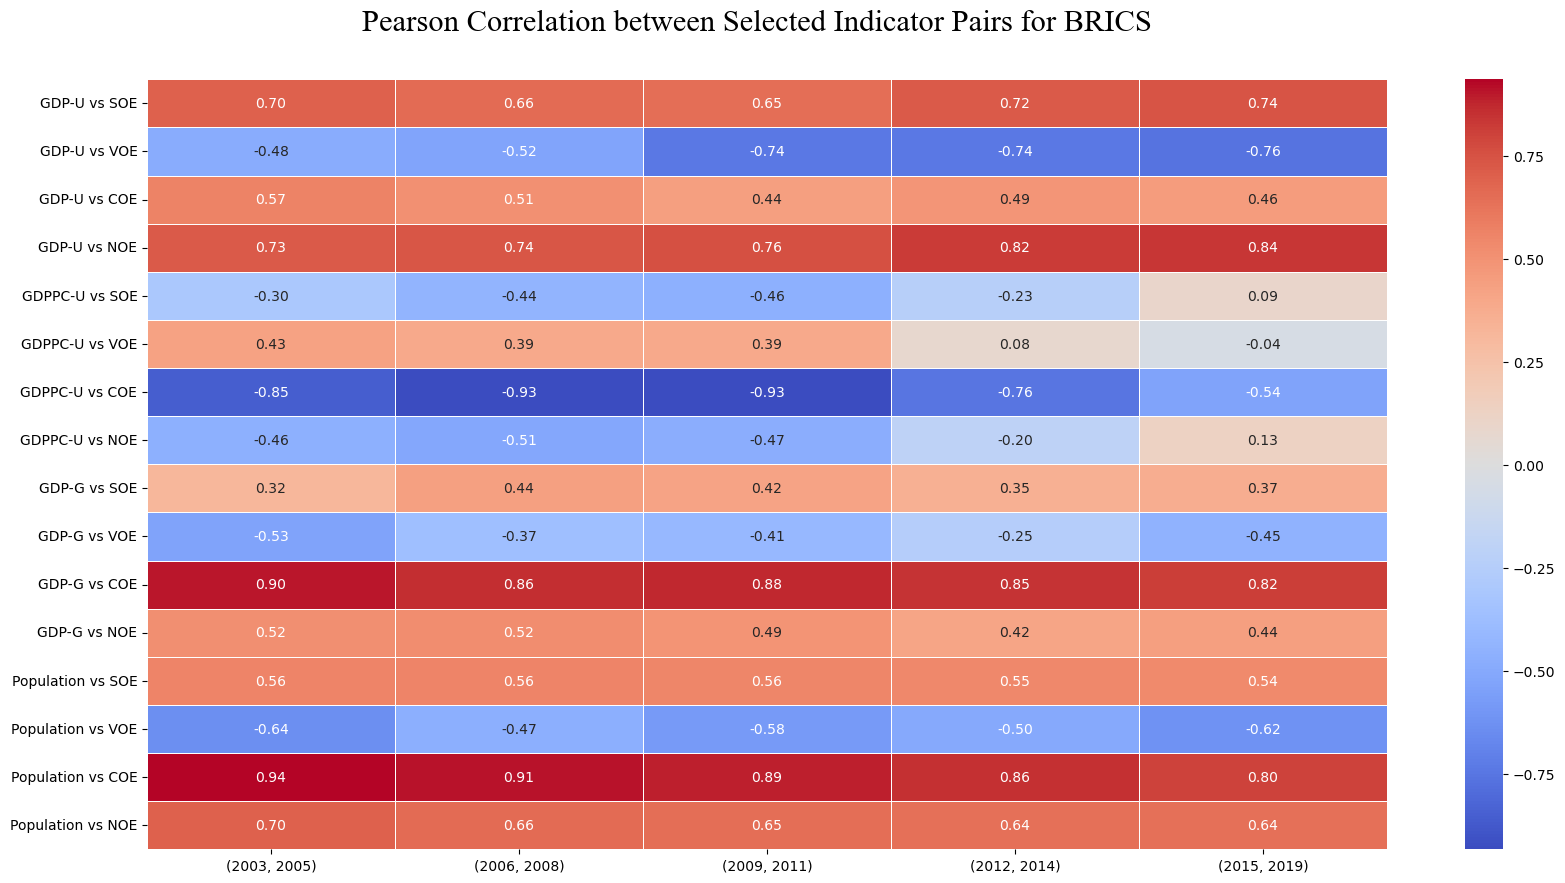

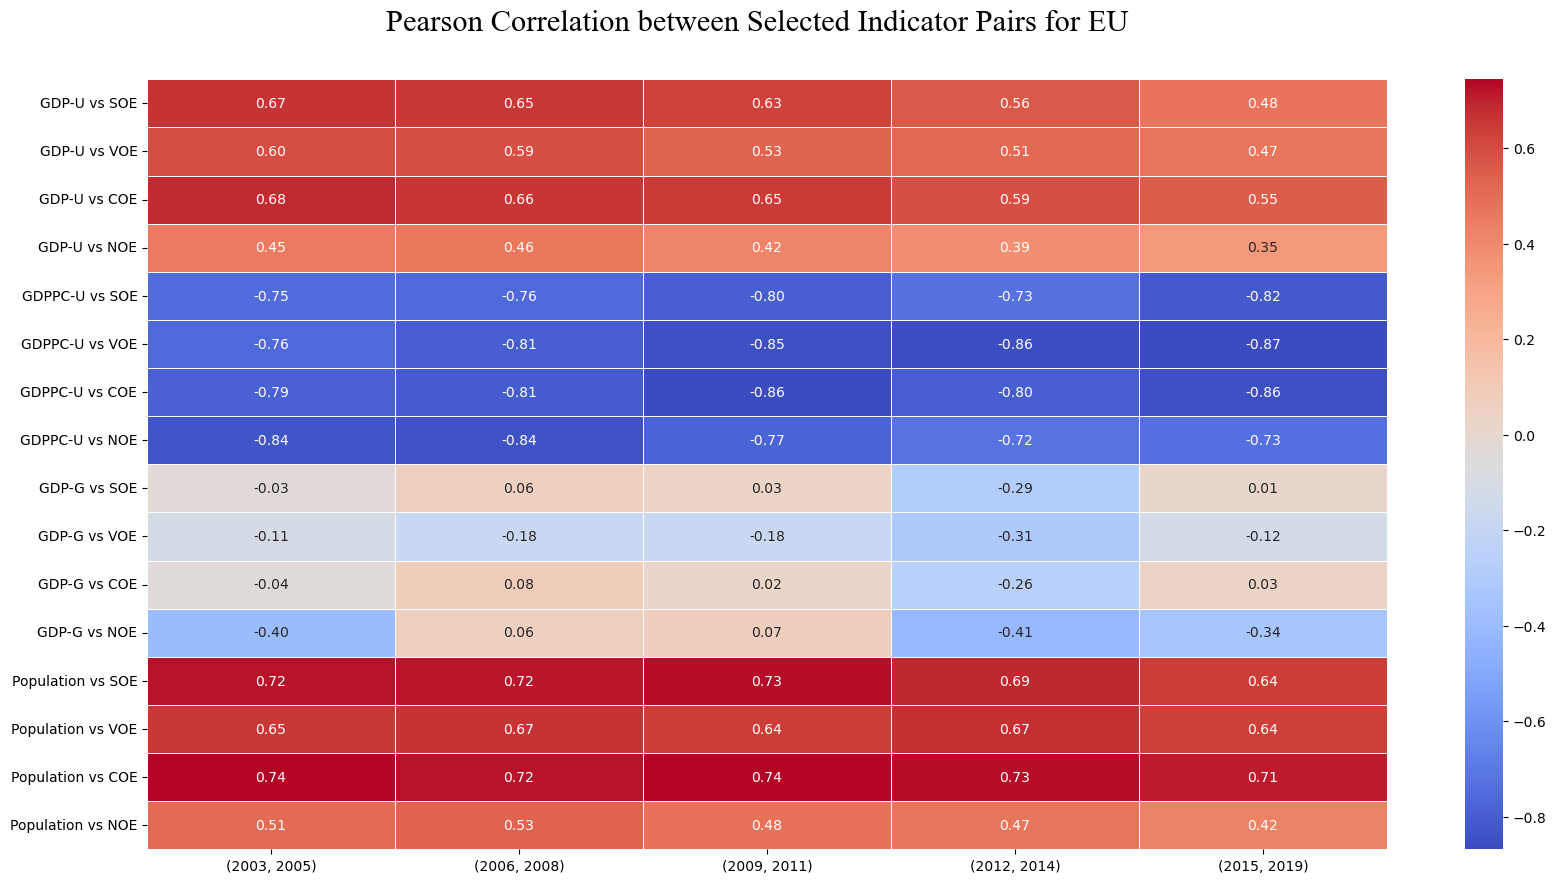

In [164]:
def get_organization_data(data, organization_dict):
    organization_data = data.copy()
    organization_data['organization'] = organization_data['country'].map(organization_dict)
    return organization_data


def plot_organization_heatmap(organization, organization_data, indicator_pairs):
    organization_data = organization_data[organization_data["organization"] == organization]
    years = sorted(organization_data['year'].unique())
    years = [year for year in years if year >= 2003 and year <=2019]
    year_intervals = []
    start_year = years[0]
    for year in years[1:]:
        if (year - start_year) == 2:
            year_intervals.append((start_year, year))
            start_year = year + 1
        elif (year - start_year) == 1 and year == years[-1]:
            year_intervals[-1] = (year_intervals[-1][0], year)
        elif (year - start_year) == 0:
            start_year = year

    correlation_matrix = np.zeros((len(indicator_pairs), len(year_intervals)))
    year_grouped = organization_data.groupby(pd.cut(organization_data['year'], bins=[
                                          interval[0] for interval in year_intervals] + [year_intervals[-1][1]]))

    for i, (indicator1, indicator2) in enumerate(indicator_pairs):
        correlations = year_grouped.apply(
            lambda group: group[indicator1].corr(group[indicator2]))
        correlation_matrix[i, :] = correlations.values
    correlation_df = pd.DataFrame(correlation_matrix, columns=year_intervals,
                                  index=[f"{pair[0]} vs {pair[1]}" for pair in indicator_pairs])
    plt.figure(figsize=(20, 10))
    sns.heatmap(correlation_df, cmap='coolwarm',
                linewidths=0.5, annot=True, fmt=".2f")
    title_font = {'fontname': 'Times New Roman', 'weight': 'bold'}
    plt.suptitle(
        f"Pearson Correlation between Selected Indicator Pairs for {organization}", y=0.95, fontdict=title_font, fontsize=22, x=0.43, ha='center')
    plt.savefig(
        f"Pearson Correlation between Selected Indicator Pairs for {organization}", dpi=800, bbox_inches='tight')
    plt.show()


selected_countries = list(organization_dict.keys())
filtered_data = merged_data[merged_data['country'].isin(selected_countries)]
organization_data = get_organization_data(filtered_data, organization_dict)

organization_order = ['NAFTA', 'BRICS', 'EU']
for organization in organization_order:
    plot_organization_heatmap(organization, organization_data, indicator_pairs_2)


<span style="font-size:20pt;">Other Exploration</span>

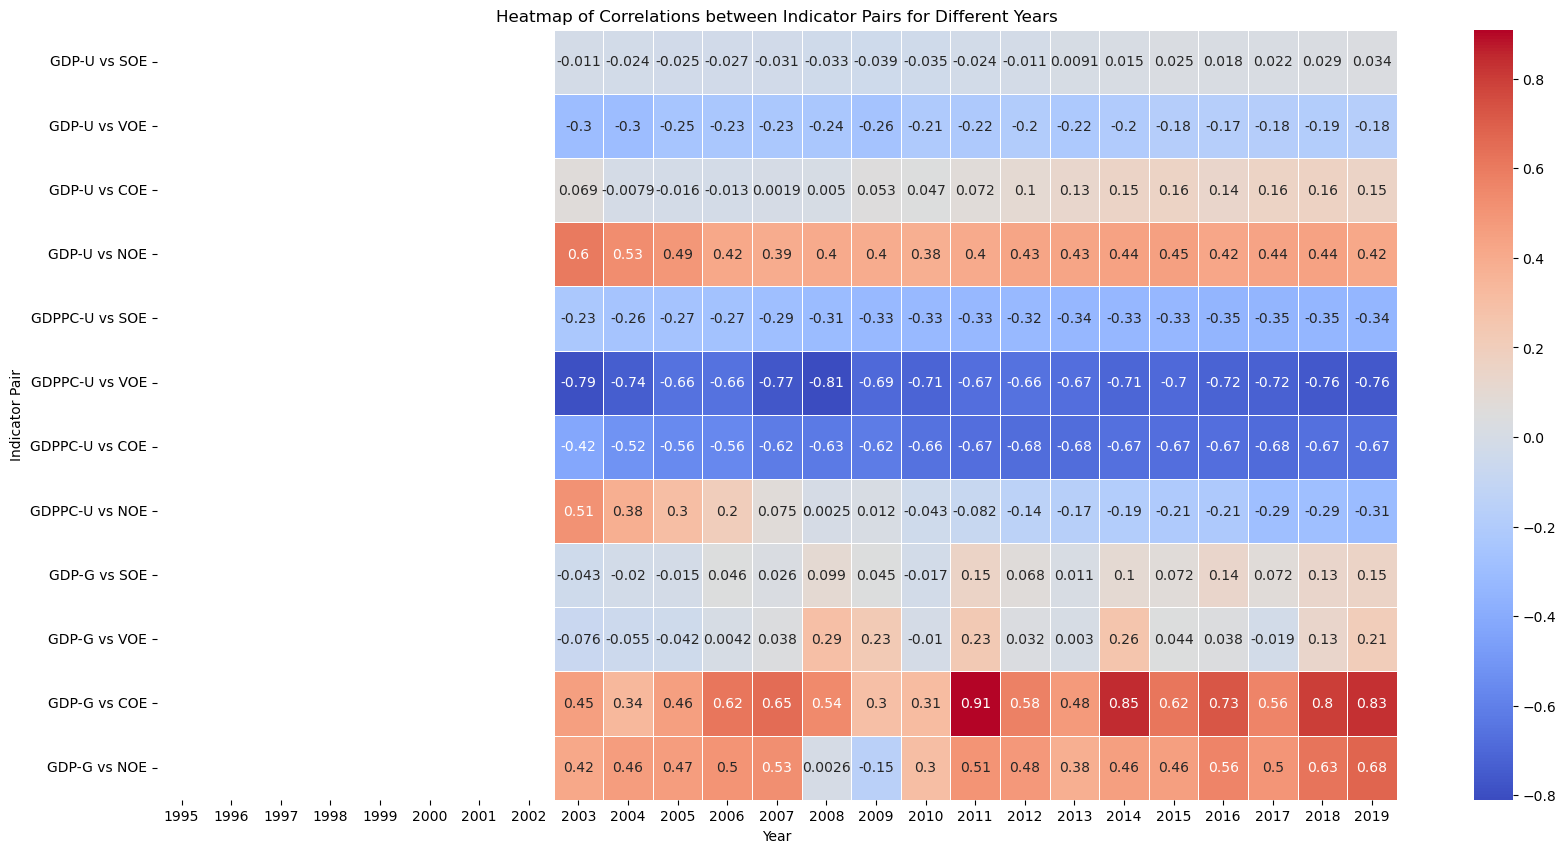

In [165]:
correlation_matrix = np.zeros((len(indicator_pairs_1), len(merged_data['year'].unique())))
for i, (indicator1, indicator2) in enumerate(indicator_pairs_1):
    correlations = merged_data.groupby("year").apply(lambda group: group[indicator1].corr(group[indicator2]))
    correlation_matrix[i, :] = correlations.values

correlation_df = pd.DataFrame(correlation_matrix, columns=merged_data['year'].unique(), index=[f"{pair[0]} vs {pair[1]}" for pair in indicator_pairs_1])

plt.figure(figsize=(20, 10))
sns.heatmap(correlation_df, cmap='coolwarm', linewidths=0.5, annot=True)
plt.title('Heatmap of Correlations between Indicator Pairs for Different Years')
plt.xlabel('Year')
plt.ylabel('Indicator Pair')
plt.show()

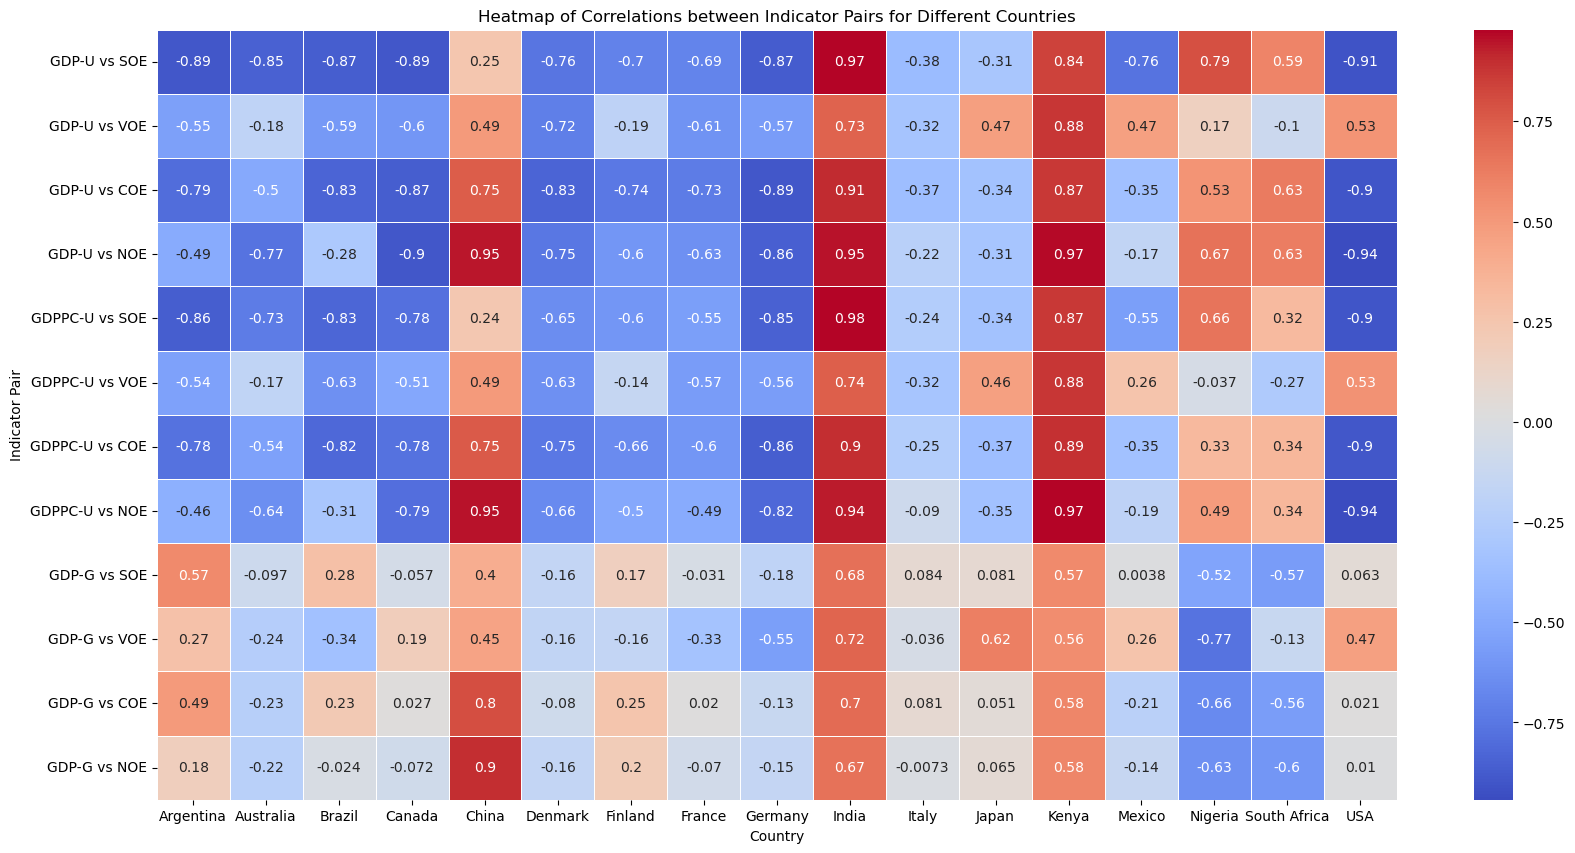

In [166]:
correlation_matrix = np.zeros((len(indicator_pairs_1), len(merged_data['country'].unique())))
for i, (indicator1, indicator2) in enumerate(indicator_pairs_1):
    correlations = merged_data.groupby("country").apply(lambda group: group[indicator1].corr(group[indicator2]))
    correlation_matrix[i, :] = correlations.values

correlation_df = pd.DataFrame(correlation_matrix, columns=merged_data['country'].unique(), index=[f"{pair[0]} vs {pair[1]}" for pair in indicator_pairs_1])

plt.figure(figsize=(20, 10))
sns.heatmap(correlation_df, cmap='coolwarm', linewidths=0.5, annot=True)
plt.title('Heatmap of Correlations between Indicator Pairs for Different Countries')
plt.xlabel('Country')
plt.ylabel('Indicator Pair')
plt.show()

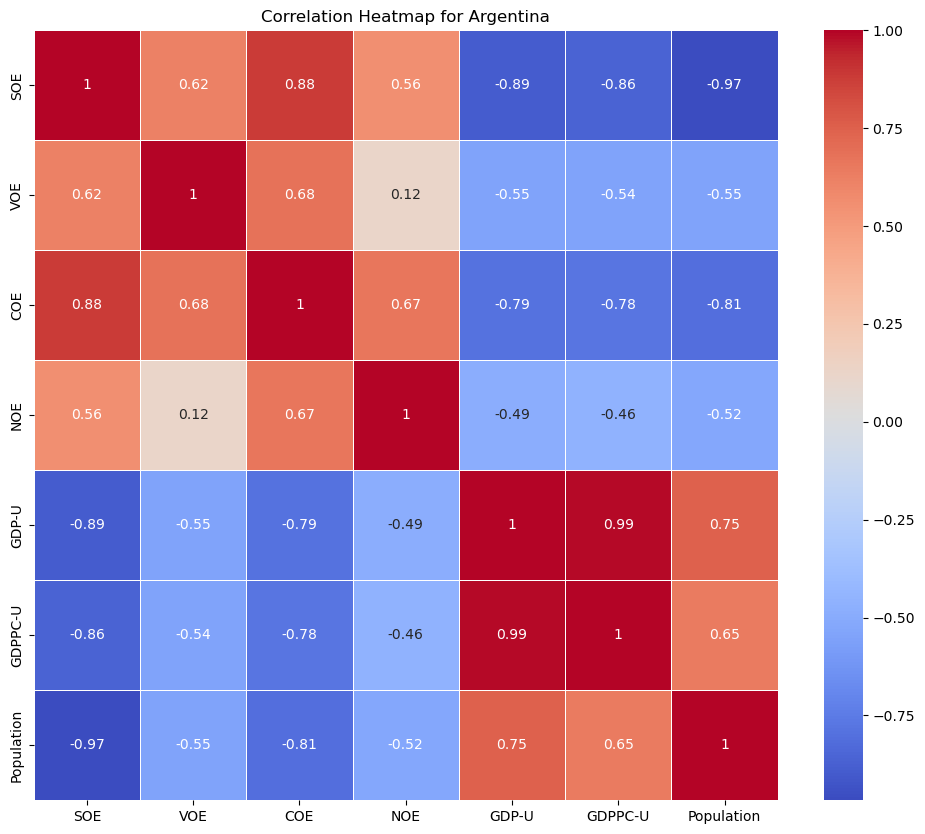

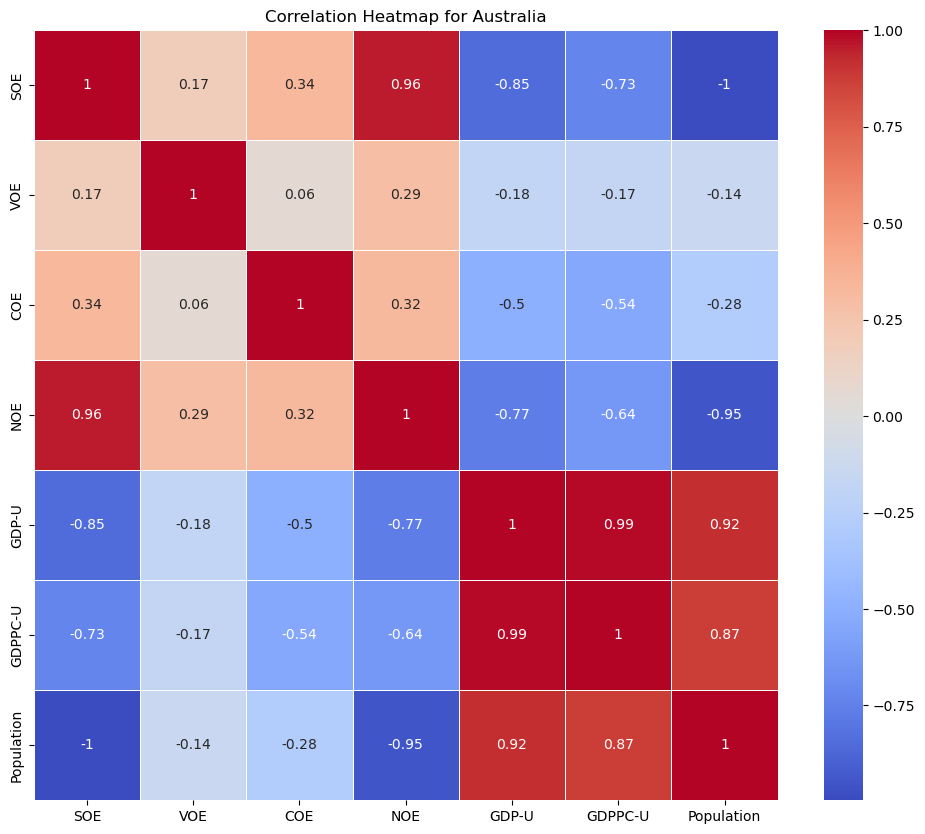

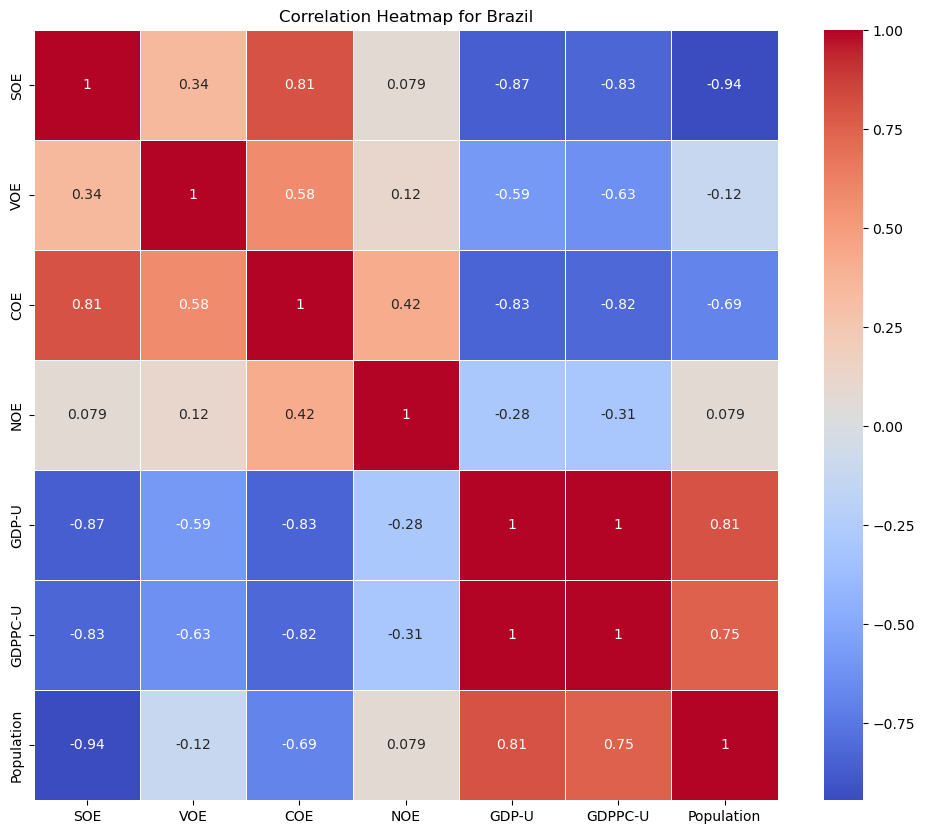

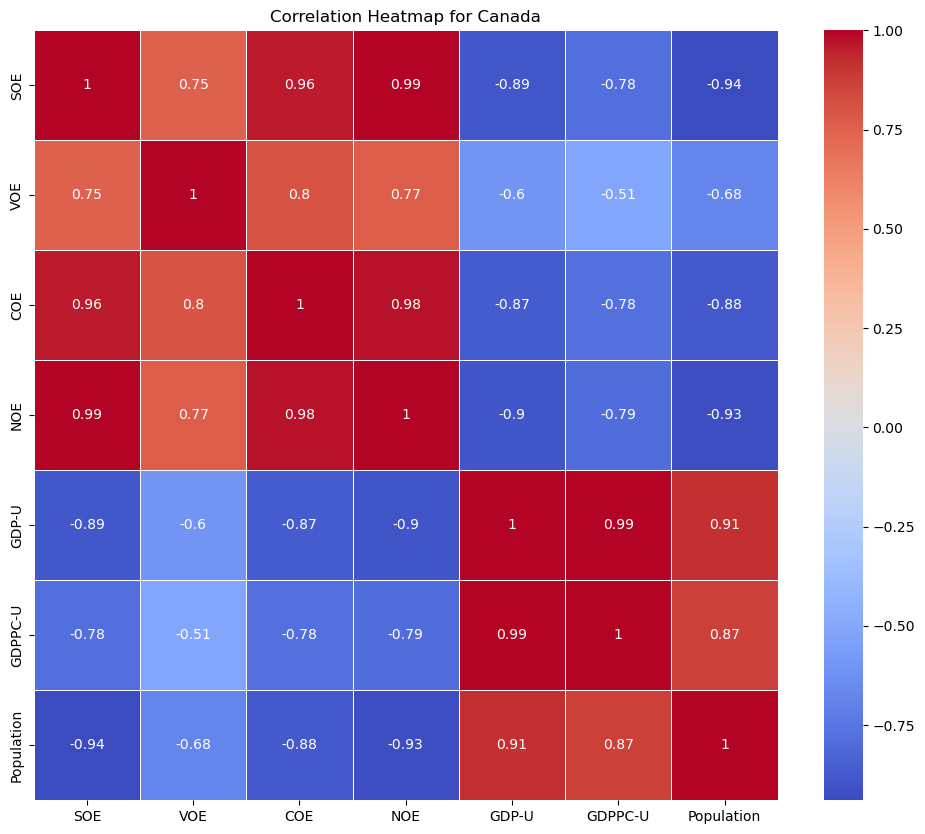

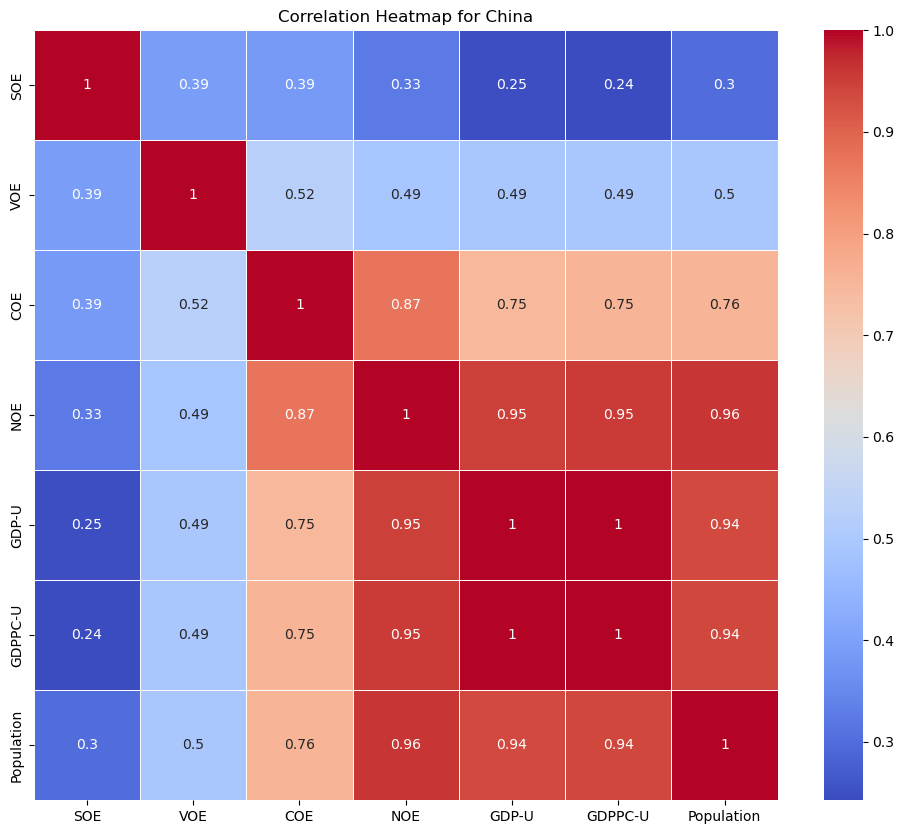

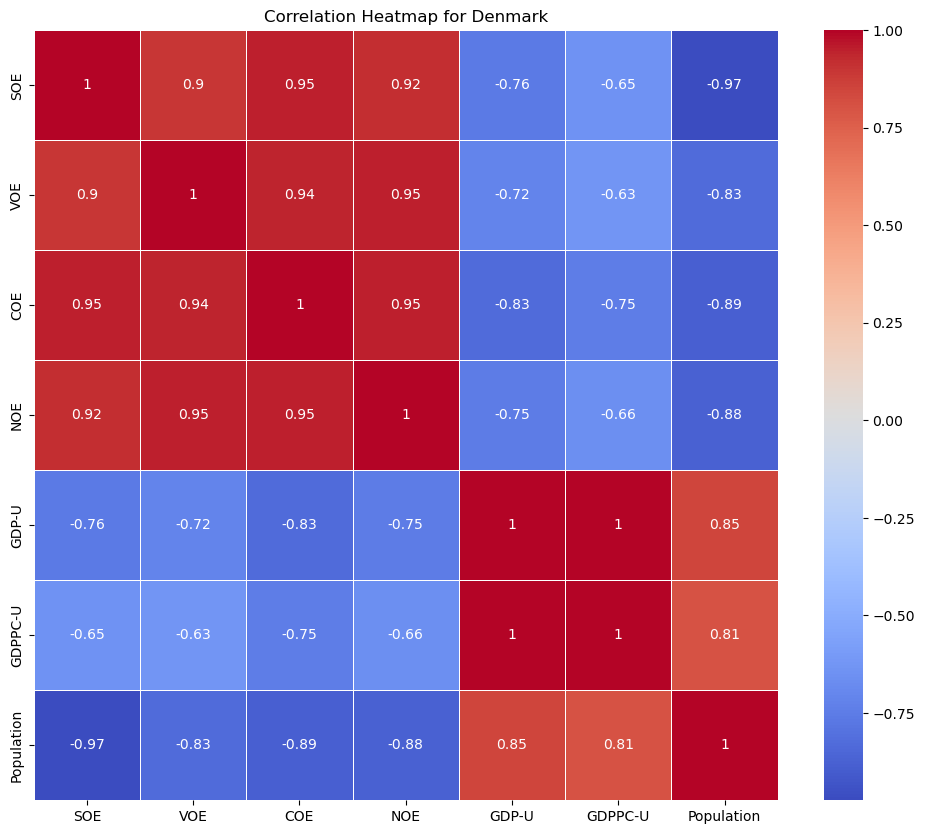

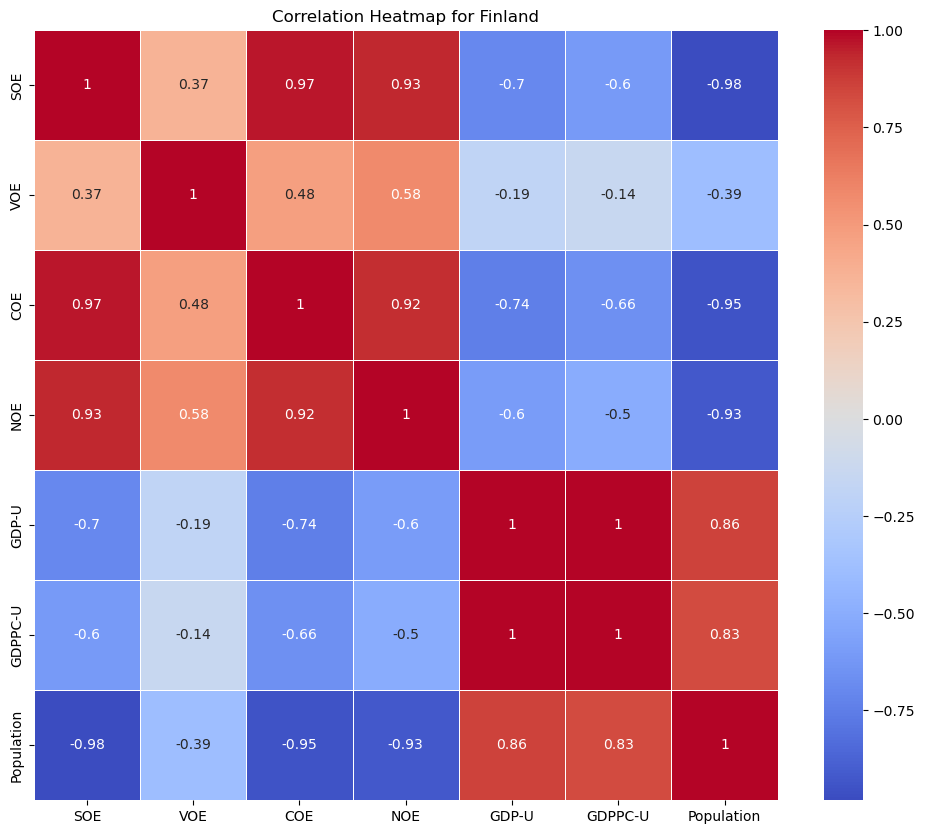

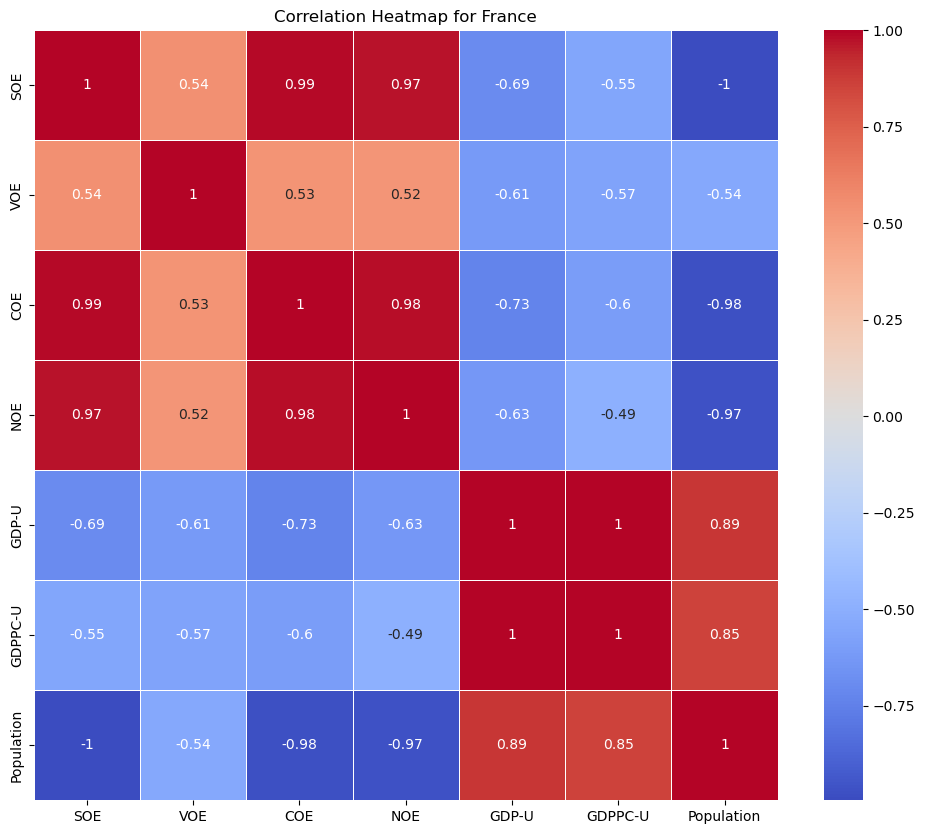

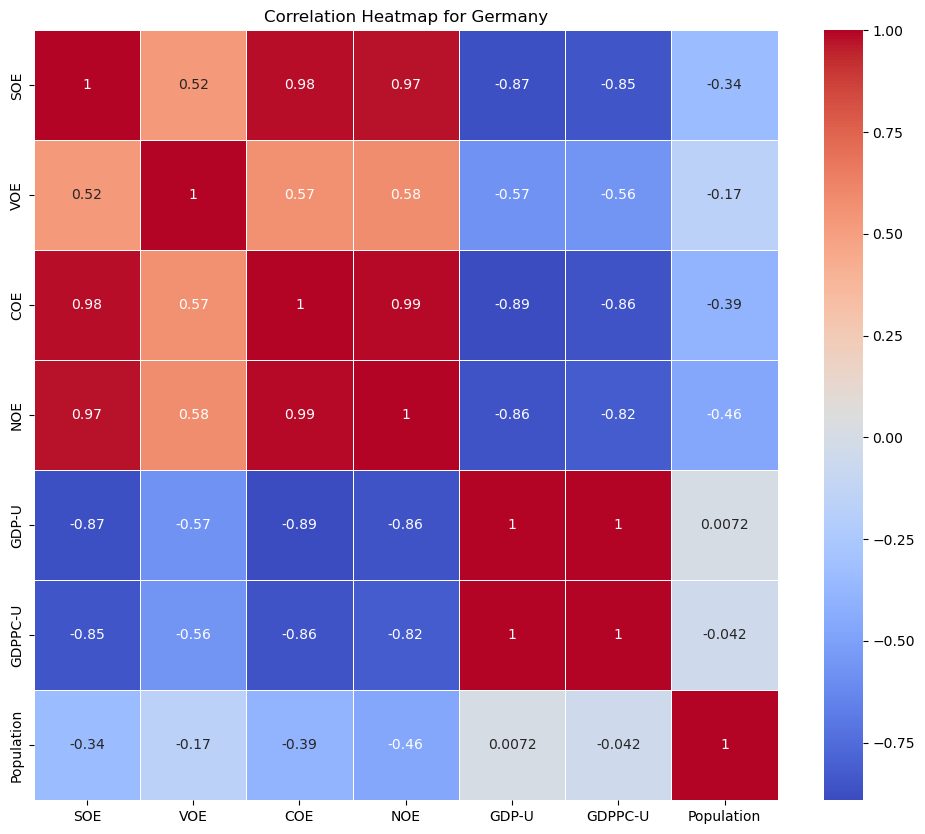

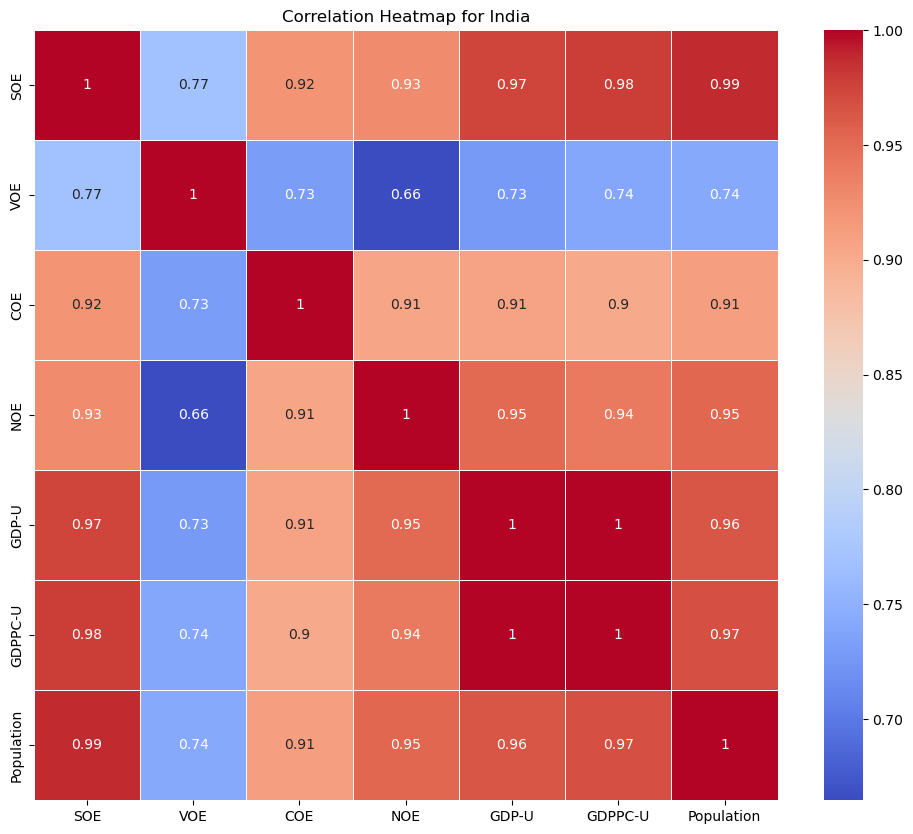

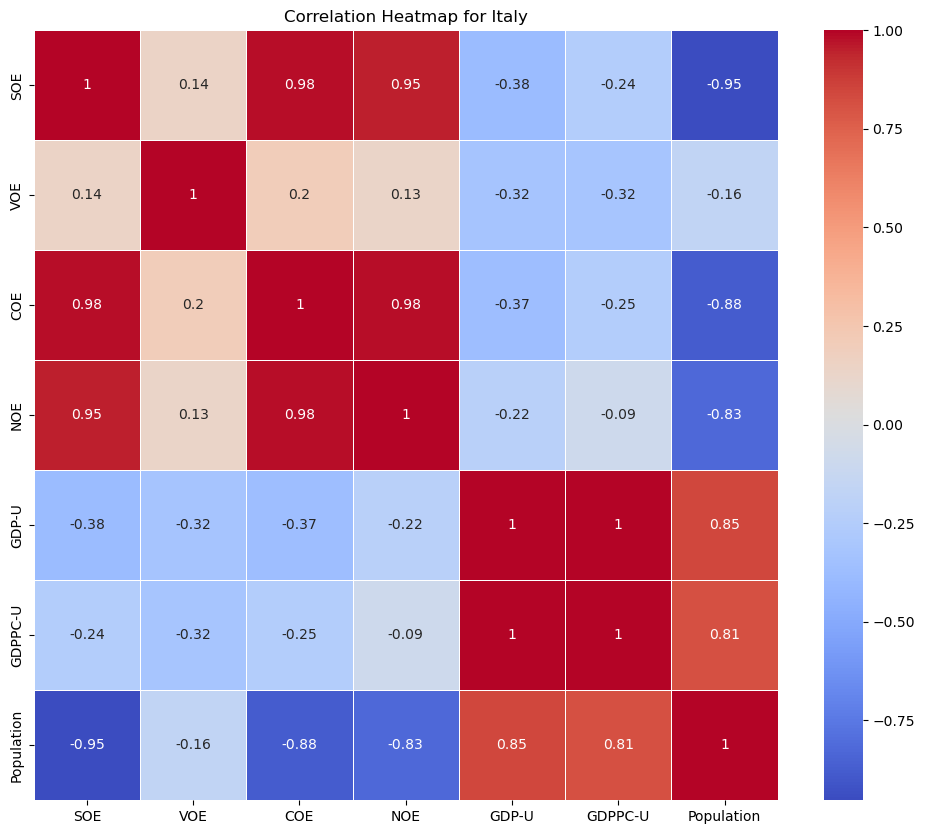

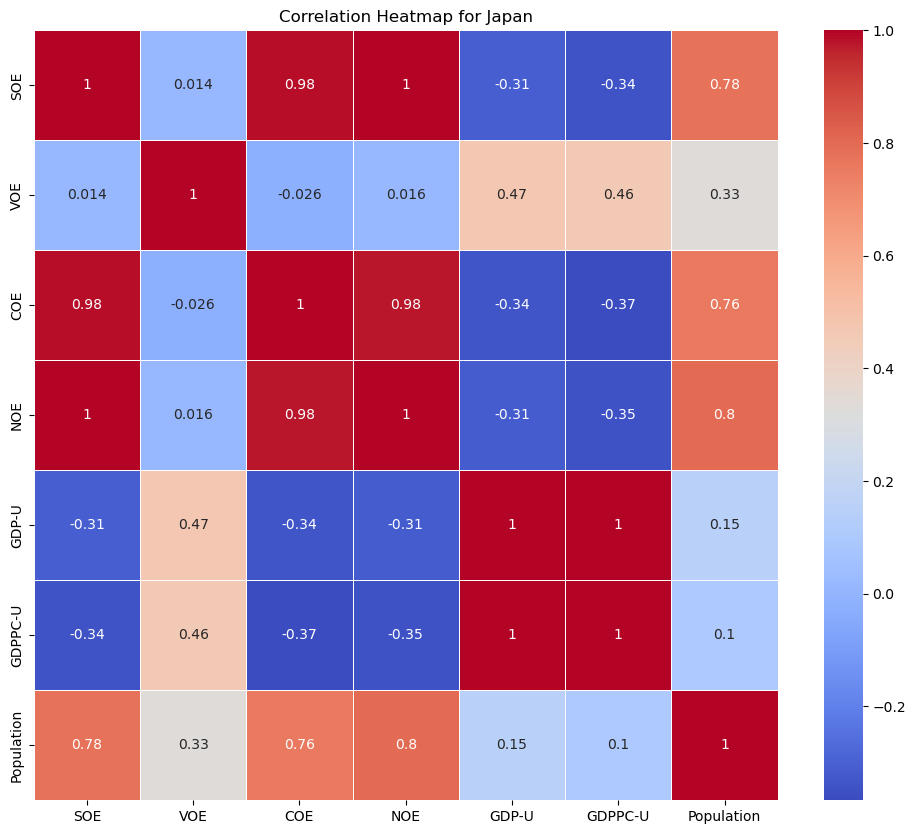

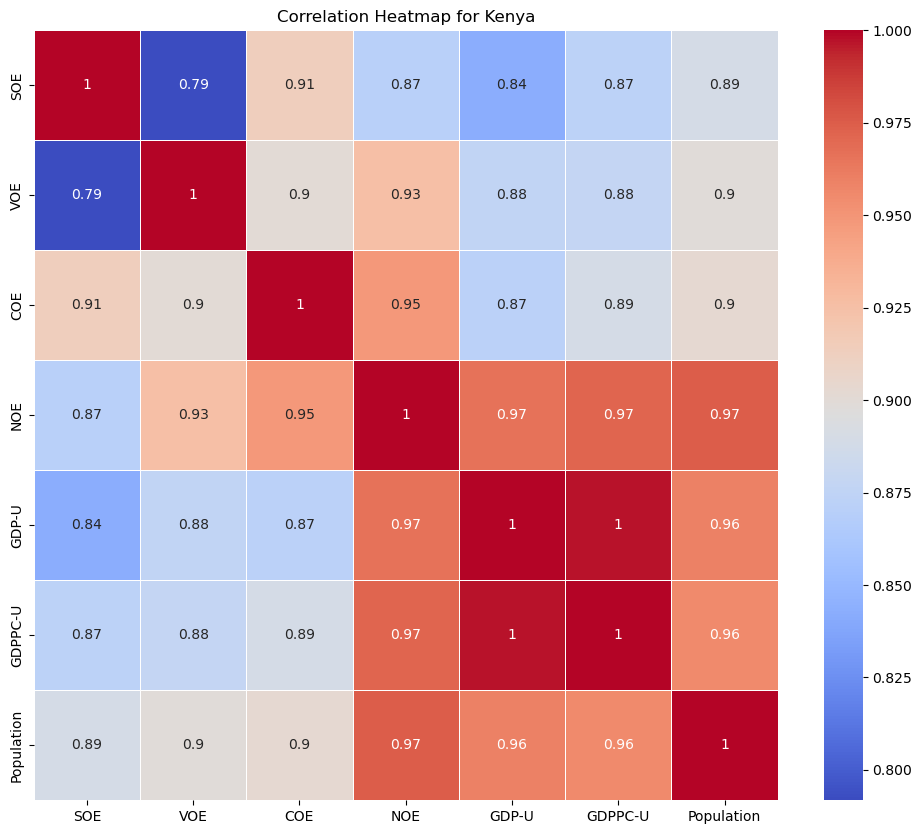

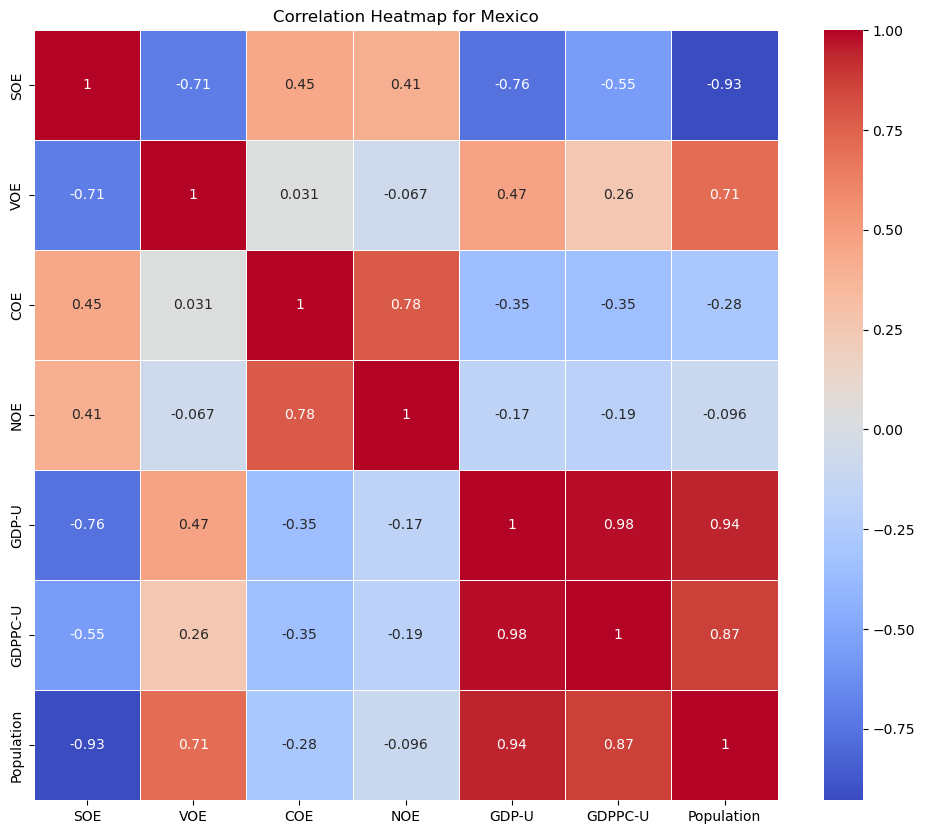

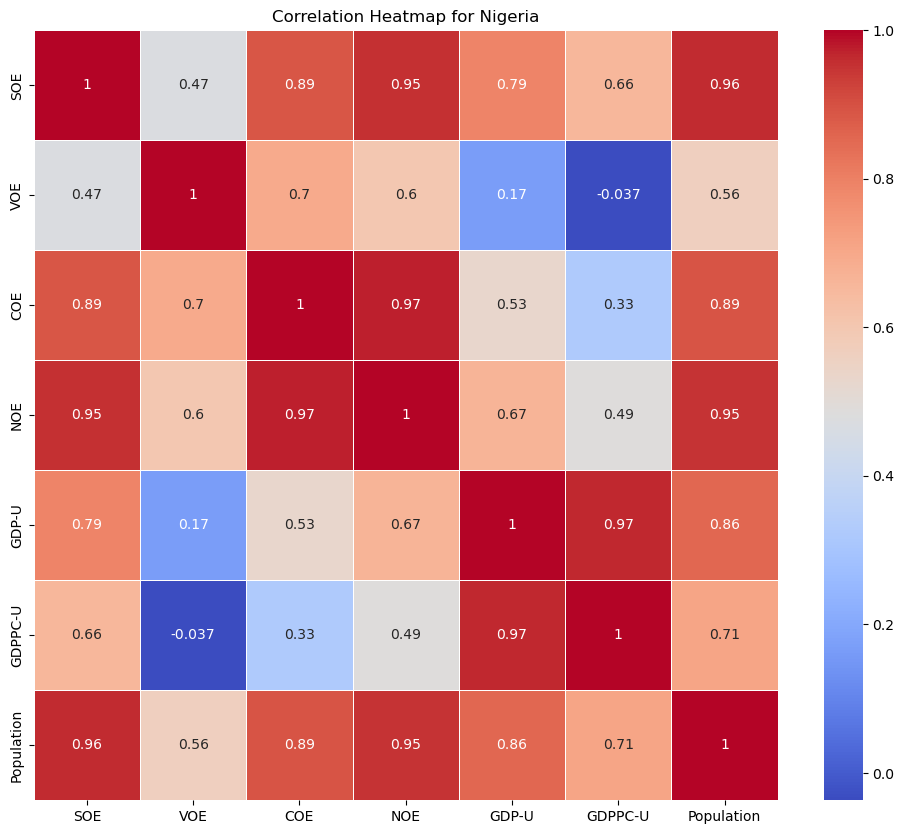

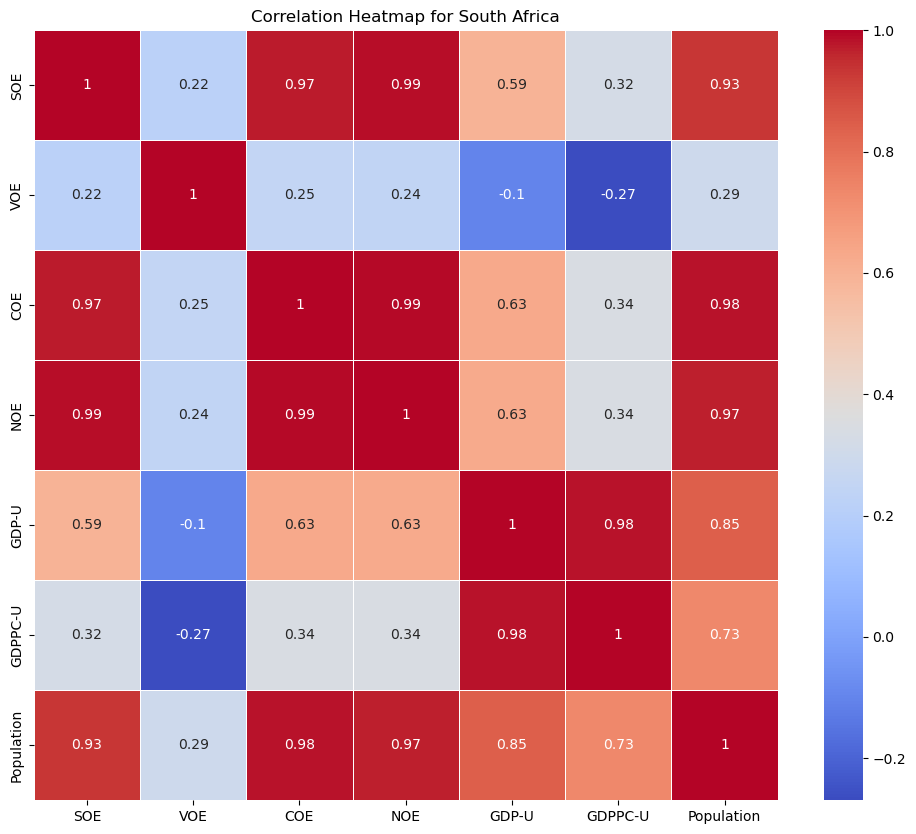

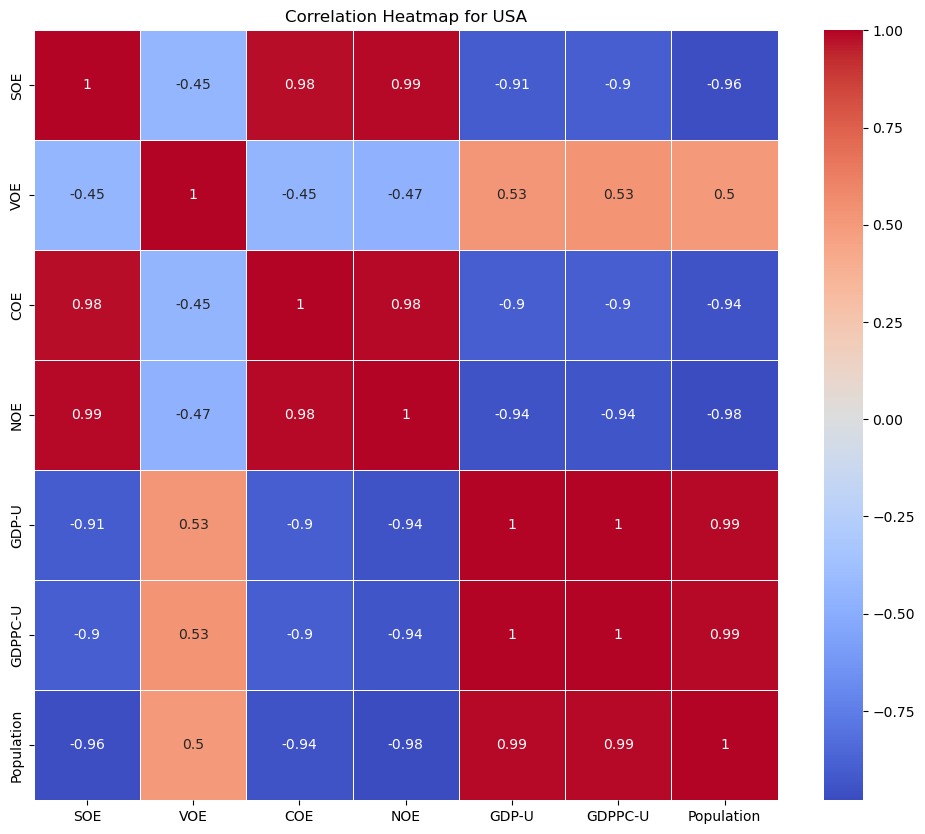

In [167]:
grouped_by_country = merged_data.groupby("country")

selected_columns = ['SOE', 'VOE', 'COE', 'NOE',
                    'GDP-U','GDPPC-U', 'Population']

for country, group in grouped_by_country:
    numeric_data = group[selected_columns]
    correlation_matrix = numeric_data.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title(f'Correlation Heatmap for {country}')
    plt.show()
